
The goal of this notebook is to demonstrate image inpainting using a Variational Autoencoder (VAE) on the MNIST dataset. Image inpainting is the process of filling in missing parts of an image or reconstructing the image from a corrupted version. Here's a breakdown of the steps involved:

1. **Data Preparation**: We load the MNIST dataset and transform the images into PyTorch tensors.

2. **Model Definition**: We define a VAE, which is a type of generative model. It consists of:
   - **Encoder**: Compresses the input image into a lower-dimensional latent space, producing a mean $\mu$ and a log-variance $\log(\sigma^2)$.
   - **Reparameterization Trick**: Samples a latent vector $z$ from the latent space using the mean and log-variance.
   - **Decoder**: Reconstructs the original image from the sampled latent vector.

3. **Loss Function**: We use a combination of two losses:
   - **Reconstruction Loss (BCE)**: Measures how well the reconstructed images match the original images.
   - **KL Divergence (KLD)**: Ensures that the learned latent space is similar to a standard normal distribution.

4. **Training**: We train the VAE on the MNIST dataset by minimizing the combined loss function using the Adam optimizer.

5. **Inpainting**: We corrupt the test images with noise and use the trained VAE to reconstruct (inpaint) the images.

6. **Visualization**: We visualize the original, noisy, and inpainted images to evaluate the performance of the VAE.

### Explanation in Math

1. **Encoder**: The encoder maps the input image $ \mathbf{x} $ to the latent space, producing a mean $ \mu $ and log-variance $ \log \sigma^2 $:
   $$ \mathbf{h} = \text{Encoder}(\mathbf{x}) \implies \mu, \log \sigma^2 = \mathbf{h} $$

2. **Reparameterization Trick**: We sample the latent vector $ \mathbf{z} $ using the mean and log-variance:
   $$ \mathbf{z} = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, \mathbf{I}) $$

3. **Decoder**: The decoder reconstructs the image $ \hat{\mathbf{x}} $ from the latent vector $ \mathbf{z} $:
   $$ \hat{\mathbf{x}} = \text{Decoder}(\mathbf{z}) $$

4. **Loss Function**: The total loss is the sum of the reconstruction loss (binary cross-entropy) and the KL divergence:
   $$ \mathcal{L} = \mathcal{L}_{\text{BCE}} + \mathcal{L}_{\text{KLD}} $$
   - **Reconstruction Loss (BCE)**:
     $$ \mathcal{L}_{\text{BCE}} = -\sum_{i=1}^{N} \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right] $$
   - **KL Divergence (KLD)**:
     $$ \mathcal{L}_{\text{KLD}} = -\frac{1}{2} \sum_{j=1}^{D} \left( 1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right) $$

5. **Training**: We minimize the total loss $ \mathcal{L} $ over the training data to optimize the parameters of the VAE.

6. **Inpainting**: We add Gaussian noise to the test images, encode them into the latent space, and then decode them to reconstruct the original images. This process demonstrates the VAE's ability to perform inpainting.

### Visualization

- **Original Images**: Show the clean, uncorrupted images from the MNIST dataset.
- **Noisy Images**: Display the images after adding Gaussian noise.
- **Inpainted Images**: Present the reconstructed images generated by the VAE from the noisy inputs.

By comparing these three sets of images, we can visually assess how well the VAE performs in recovering the original images from their noisy counterparts.


Epoch 1, Loss: 524.4026844075521
Epoch 2, Loss: 520.576713248698
Epoch 3, Loss: 518.8809019694011
Epoch 4, Loss: 518.0046335611979
Epoch 5, Loss: 517.4076440104167
Epoch 6, Loss: 517.1255044596354
Epoch 7, Loss: 516.9243775716146
Epoch 8, Loss: 516.714033203125
Epoch 9, Loss: 516.4460132486979
Epoch 10, Loss: 516.2355064778645


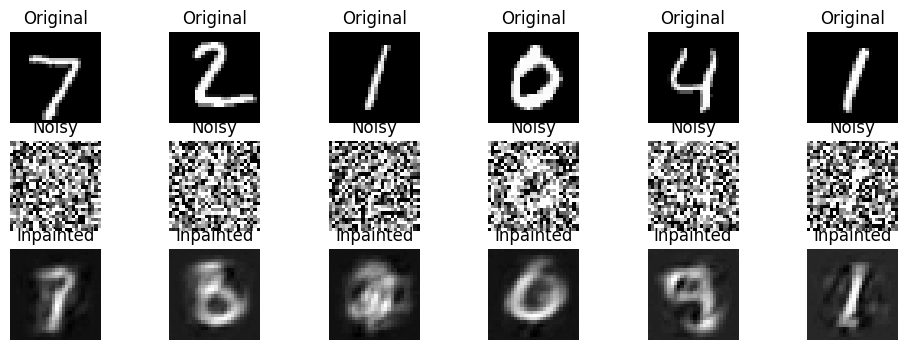

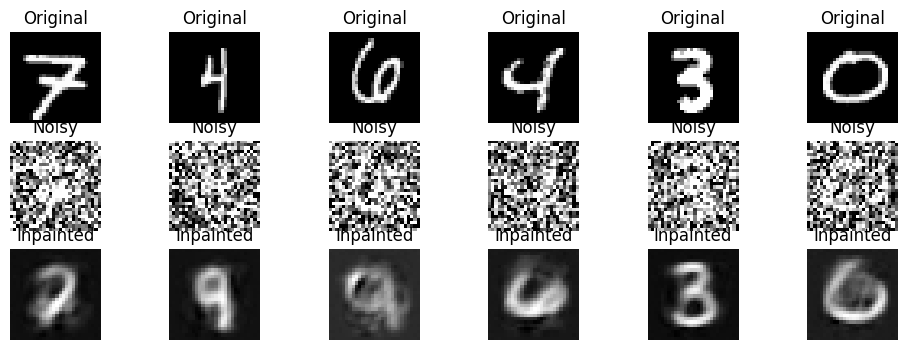

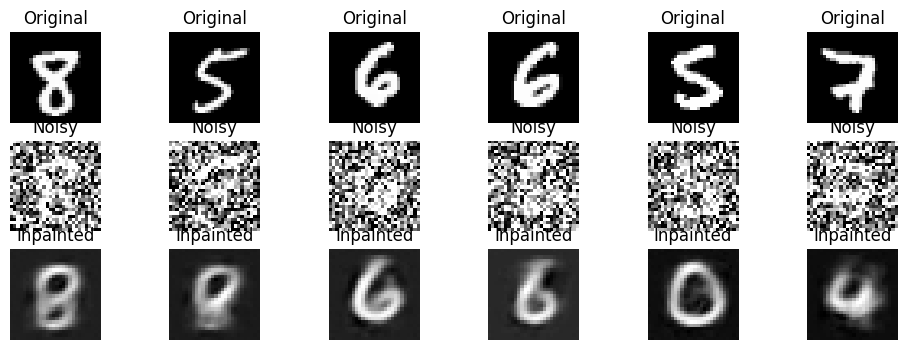

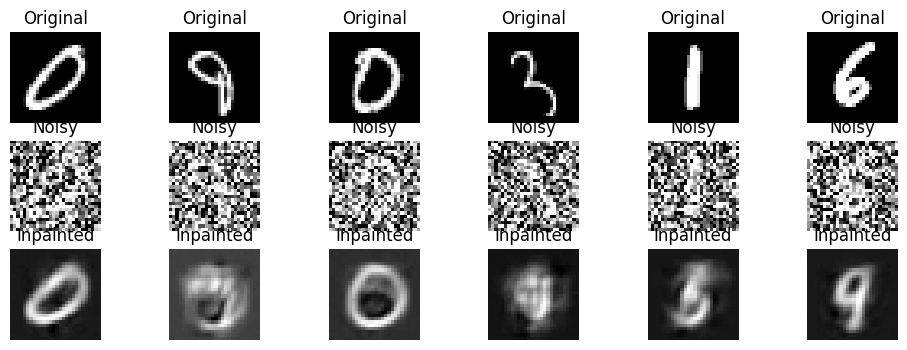

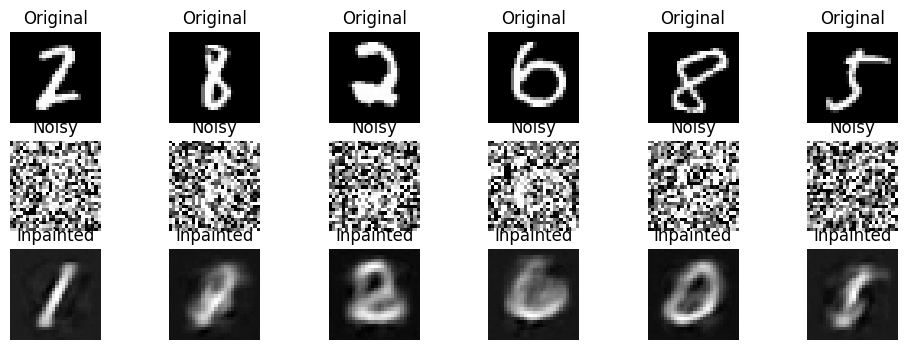

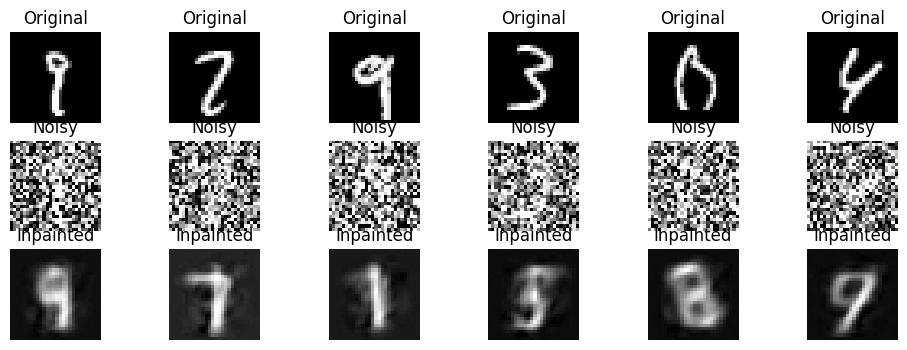

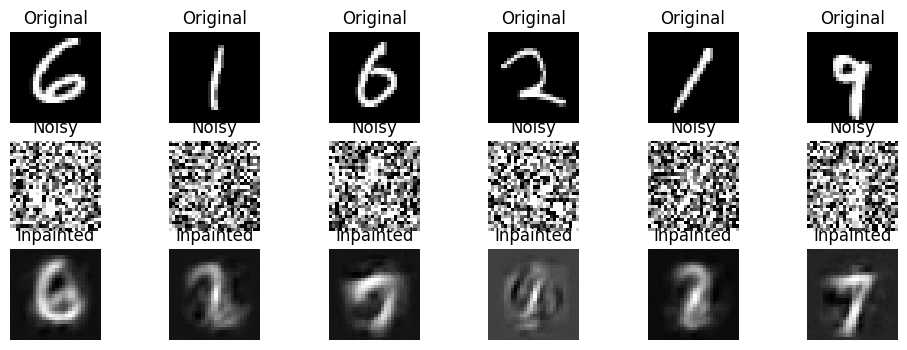

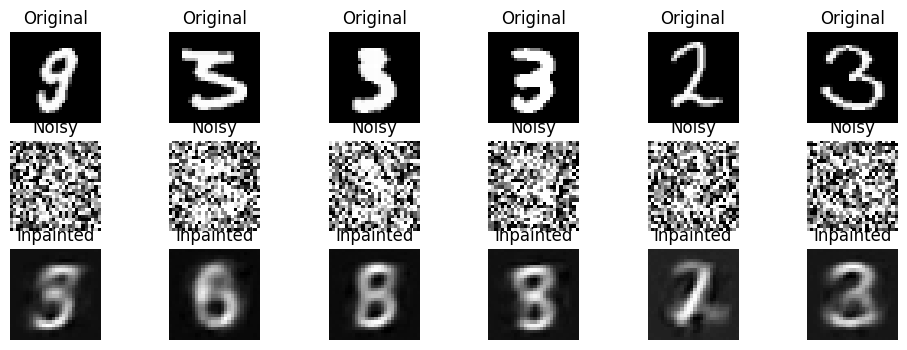

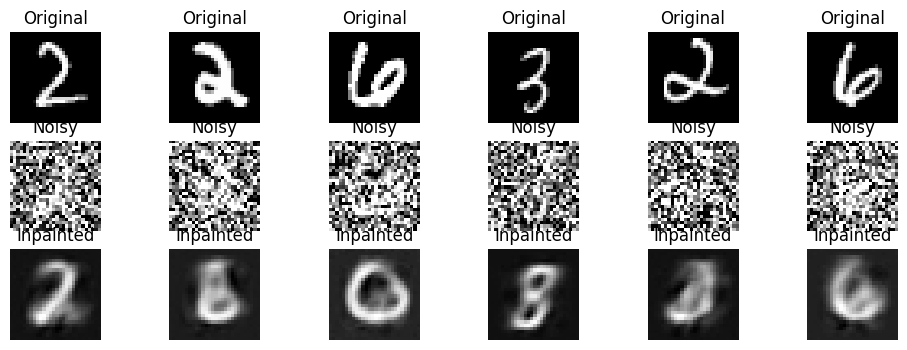

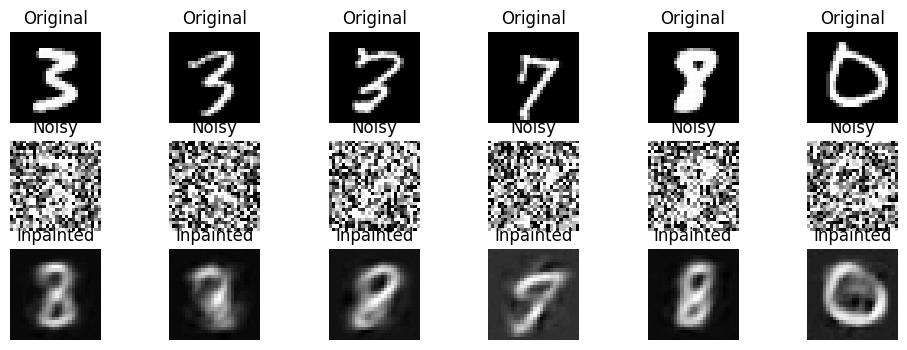

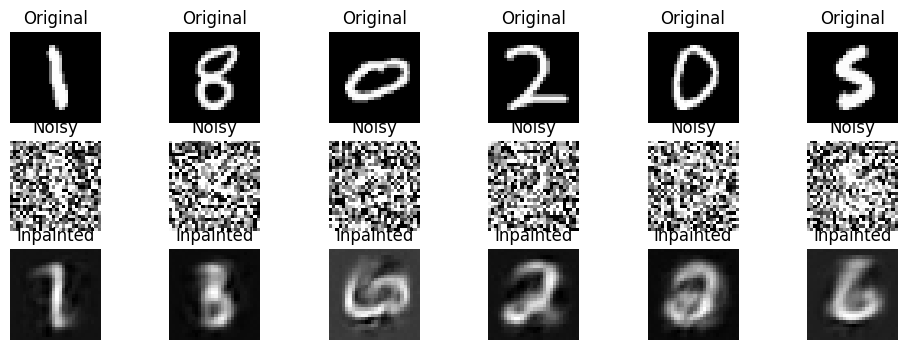

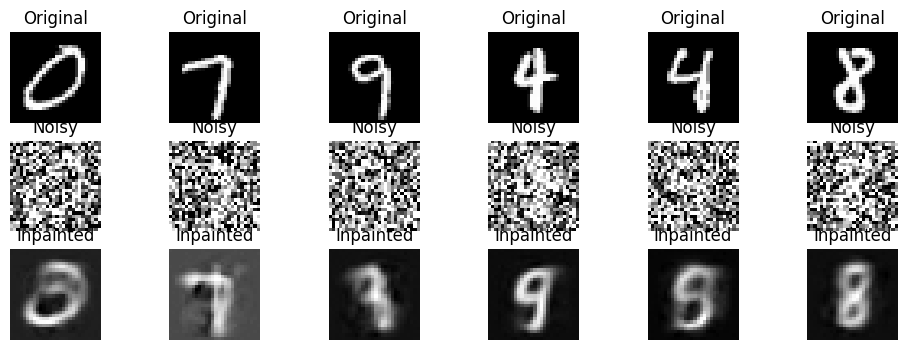

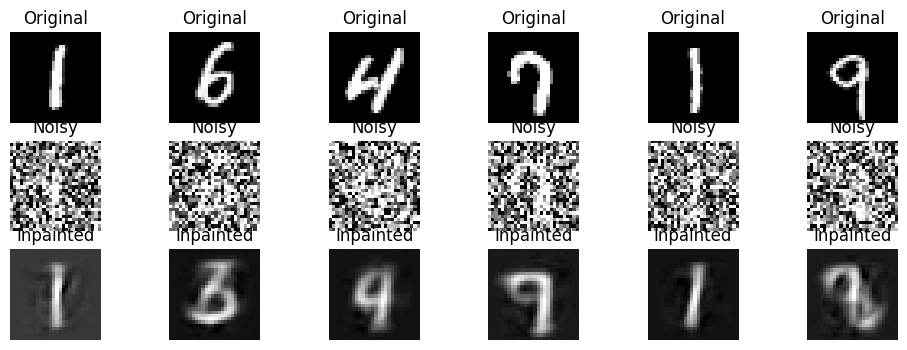

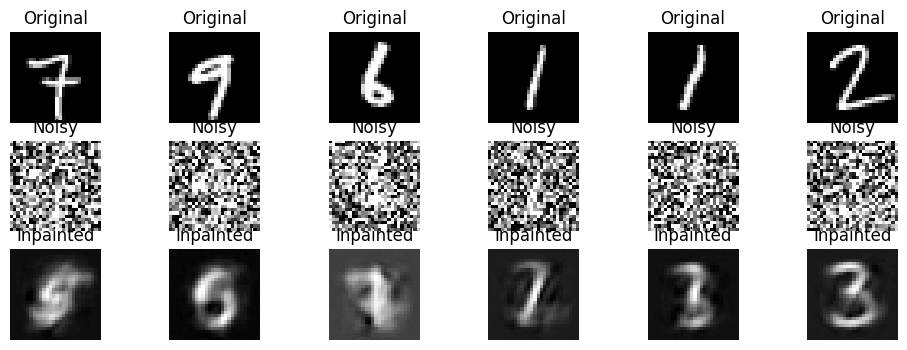

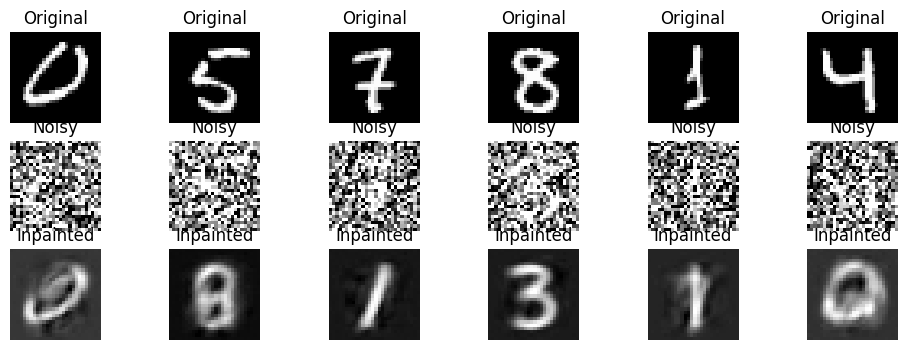

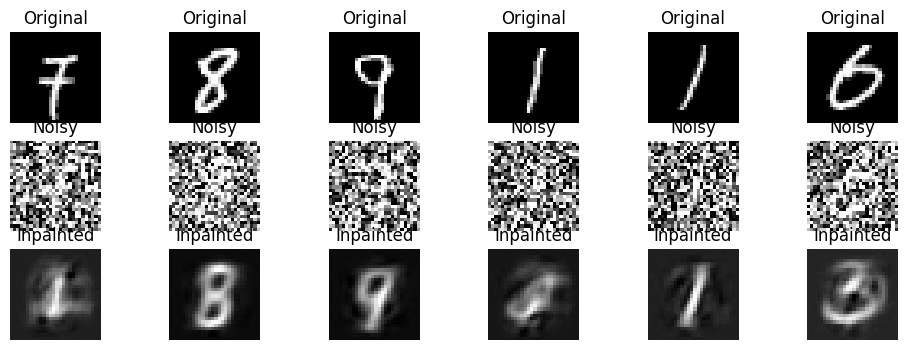

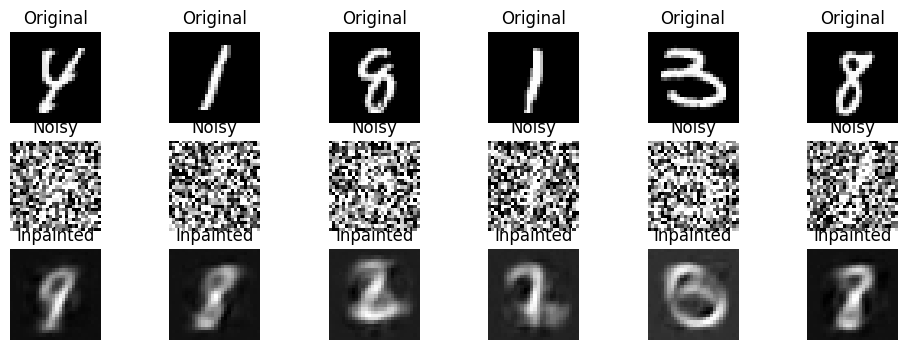

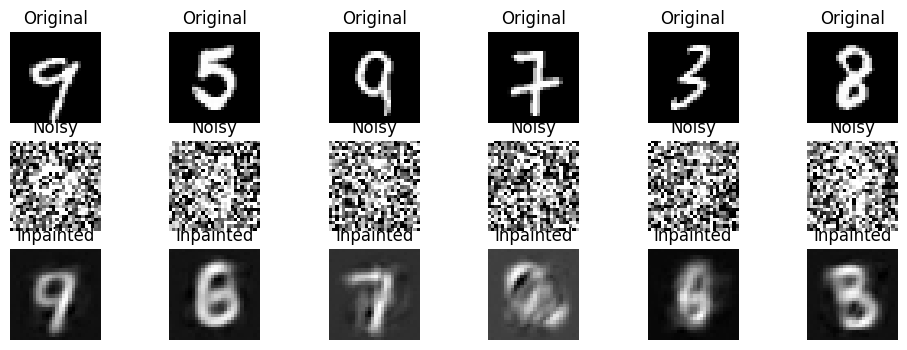

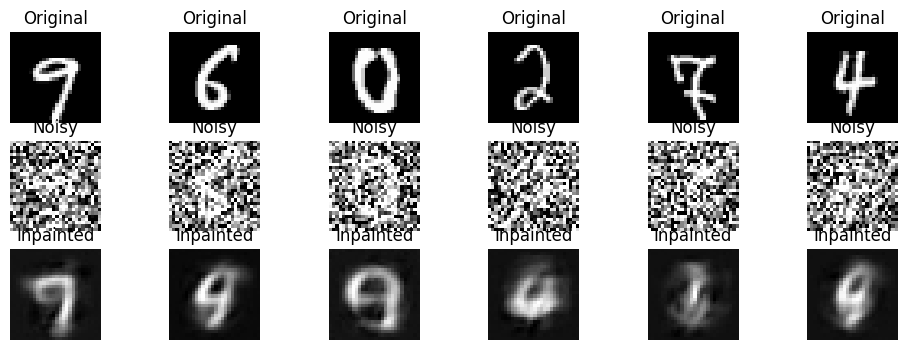

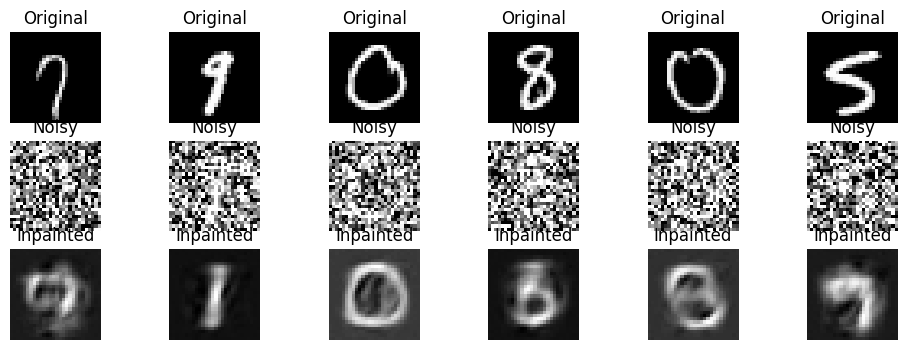

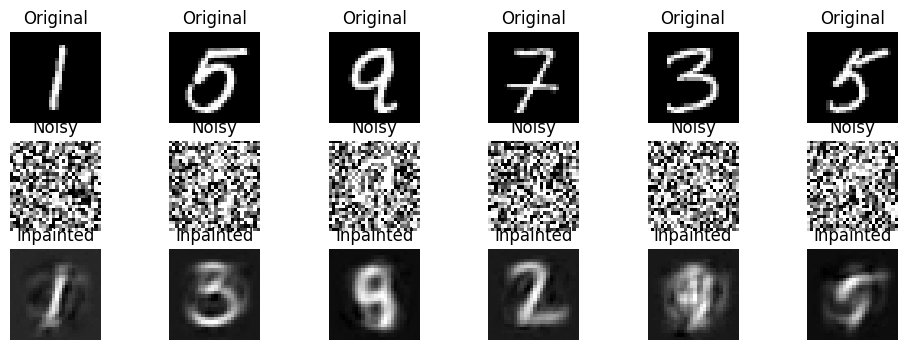

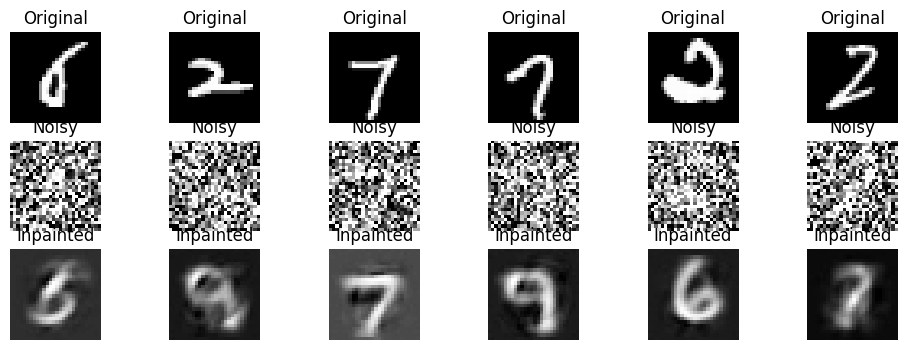

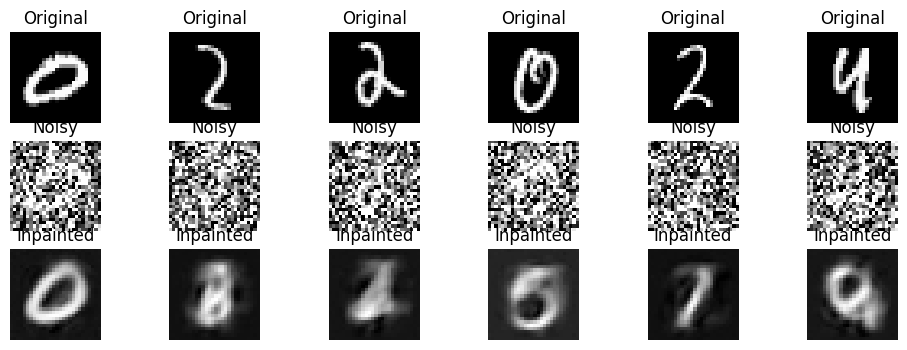

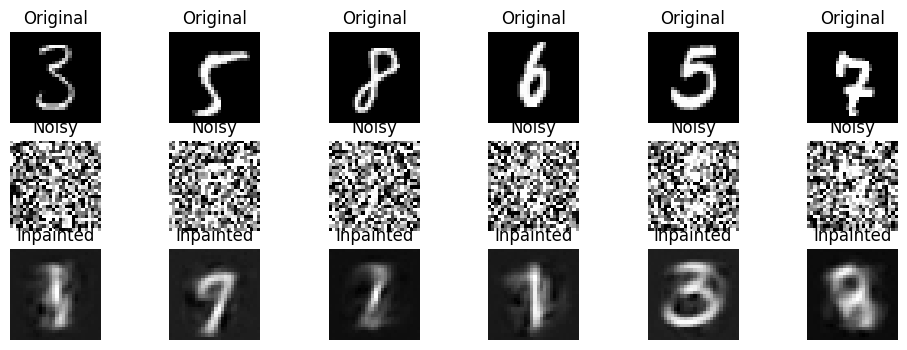

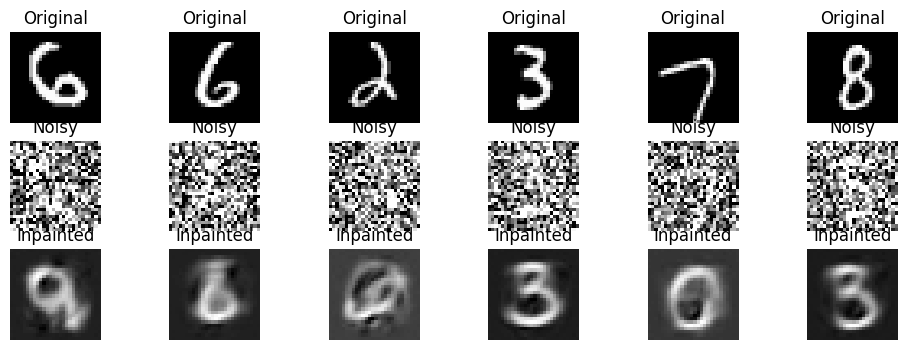

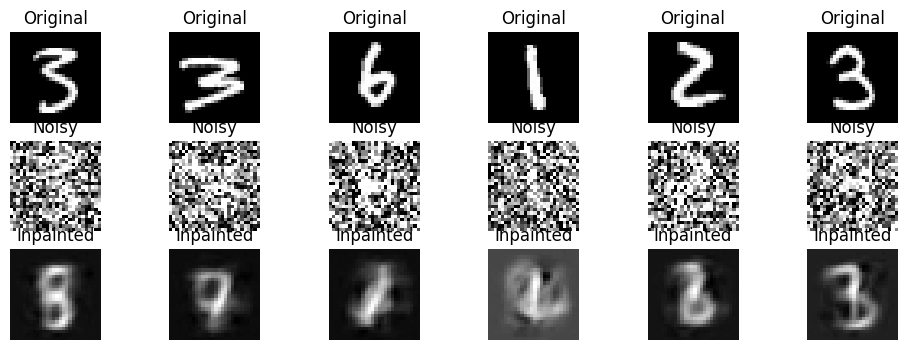

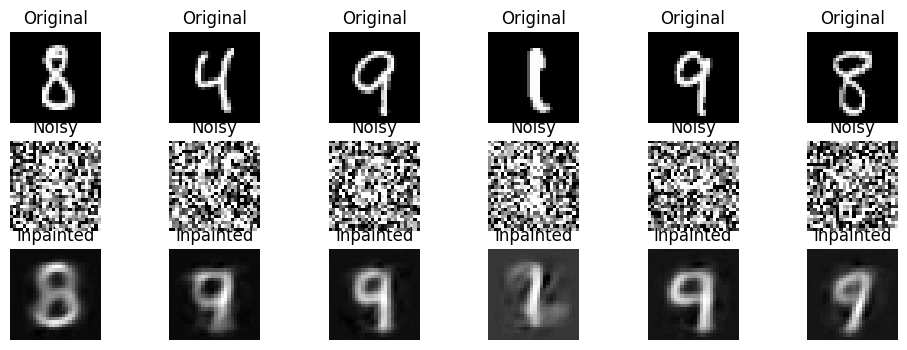

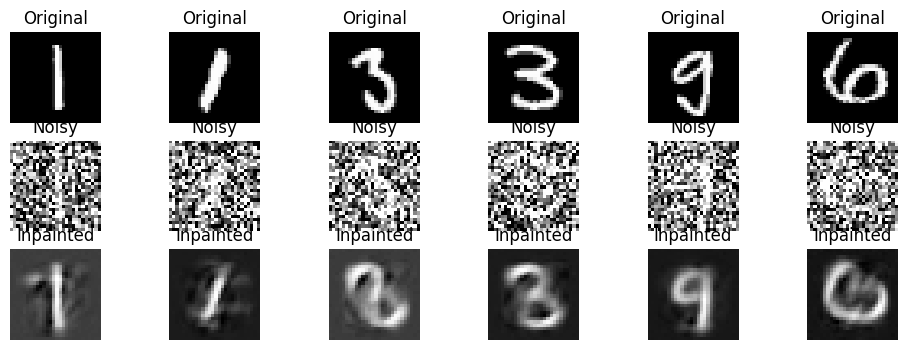

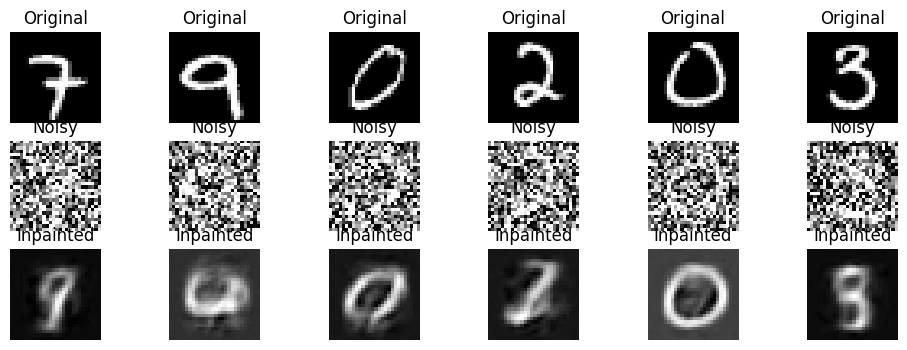

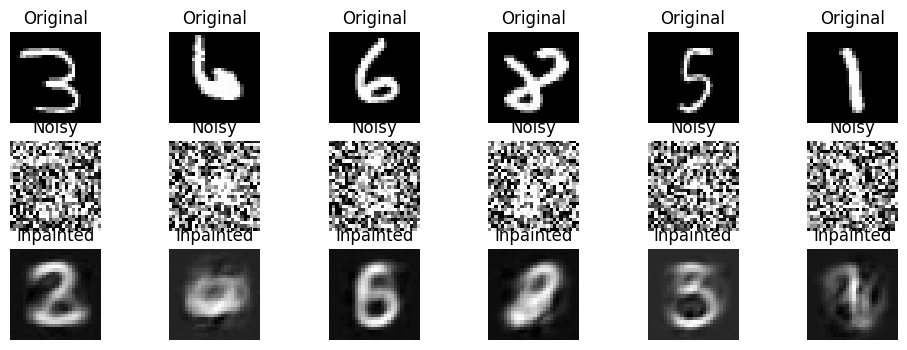

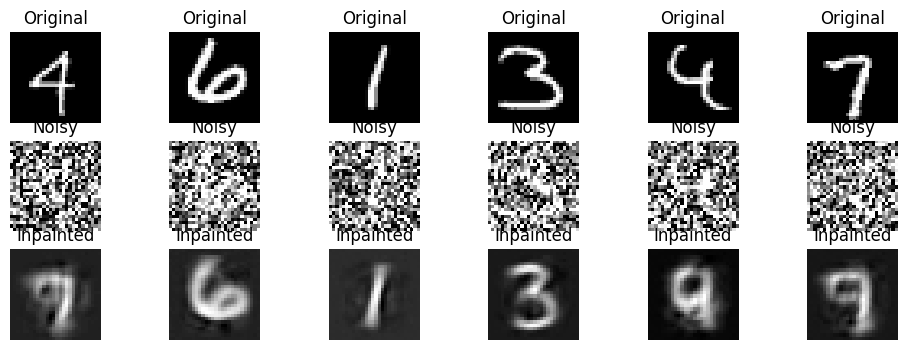

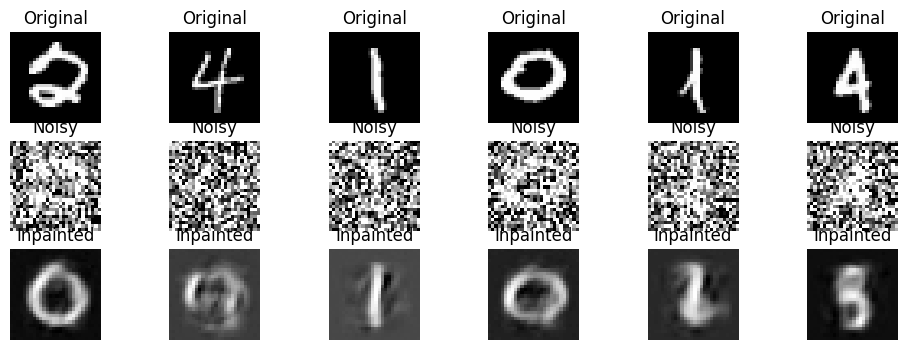

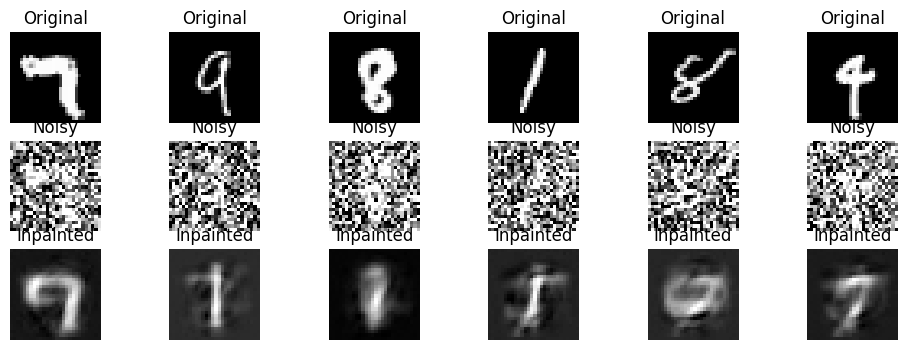

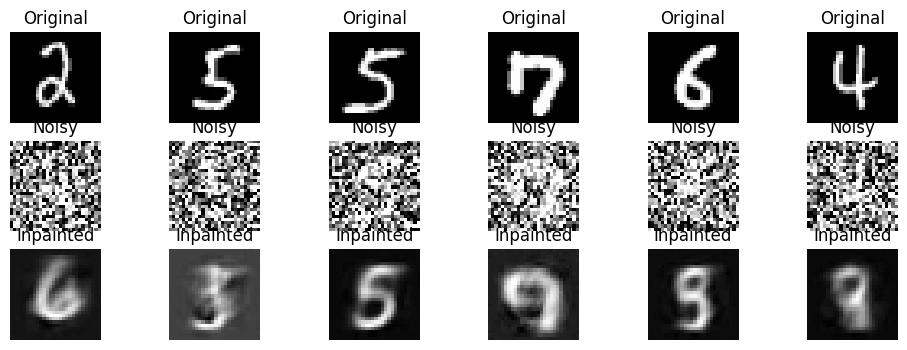

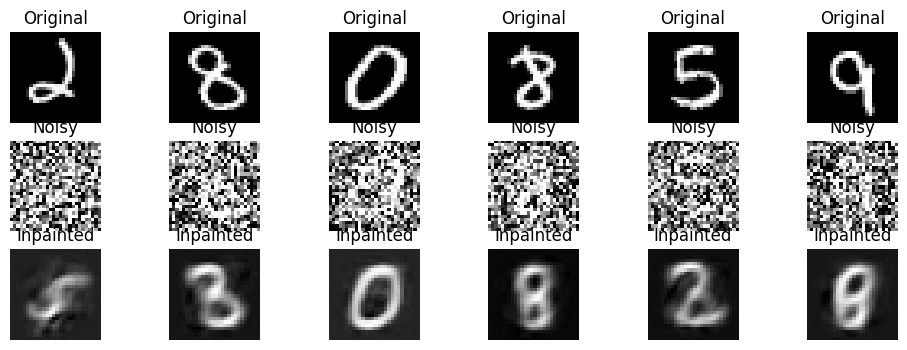

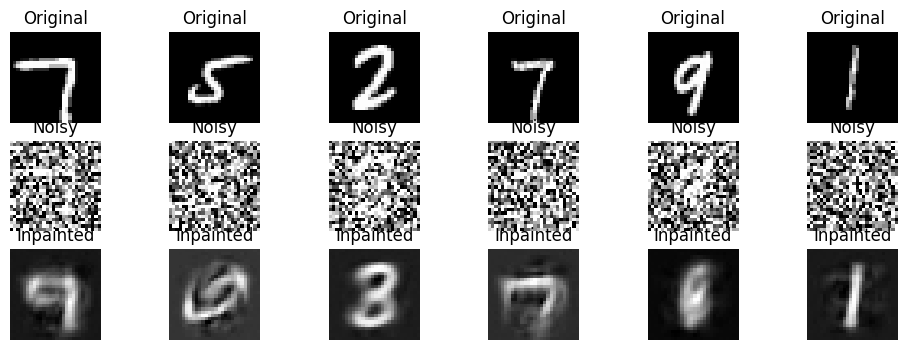

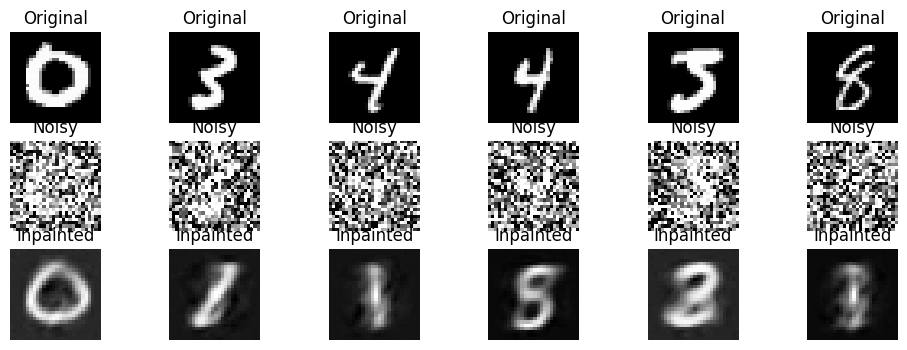

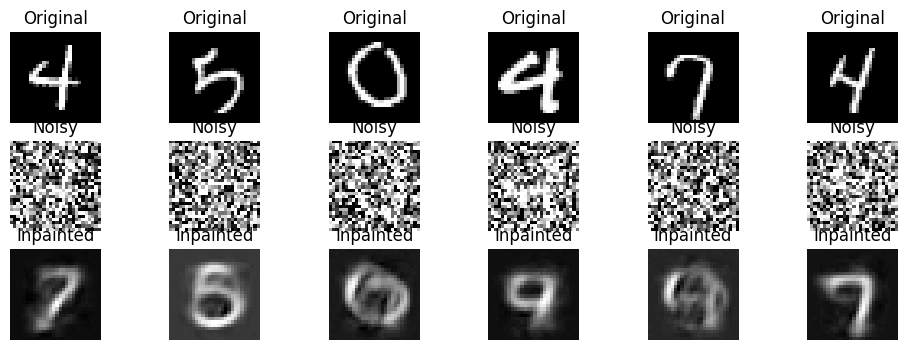

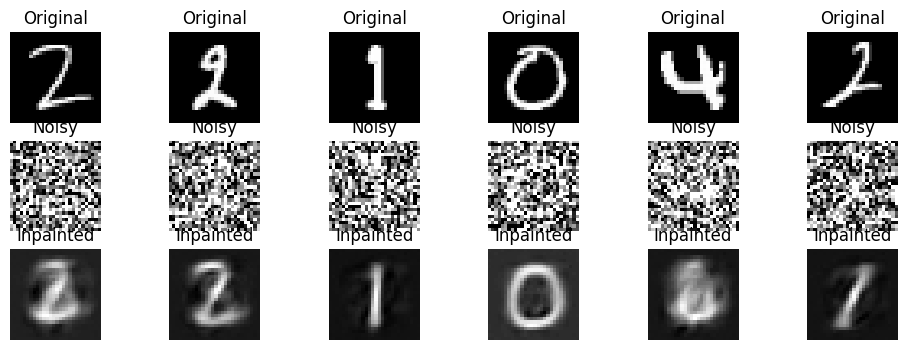

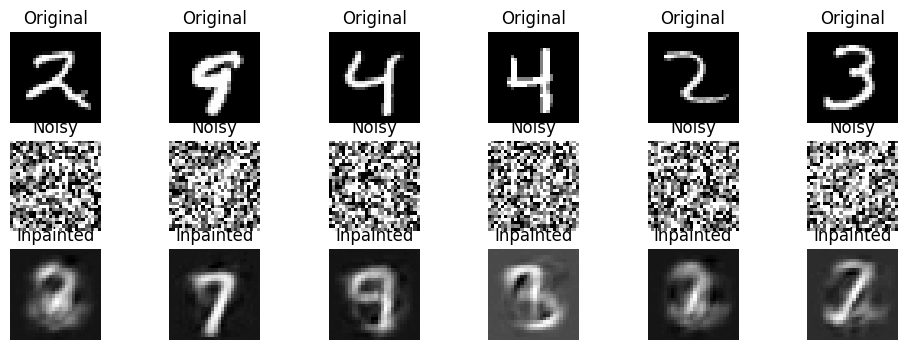

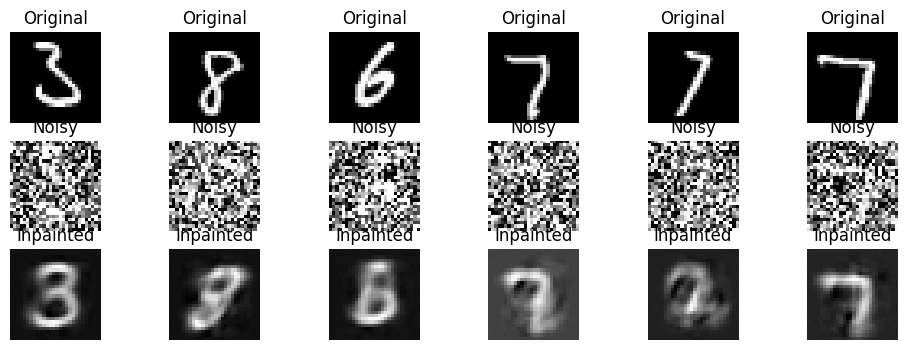

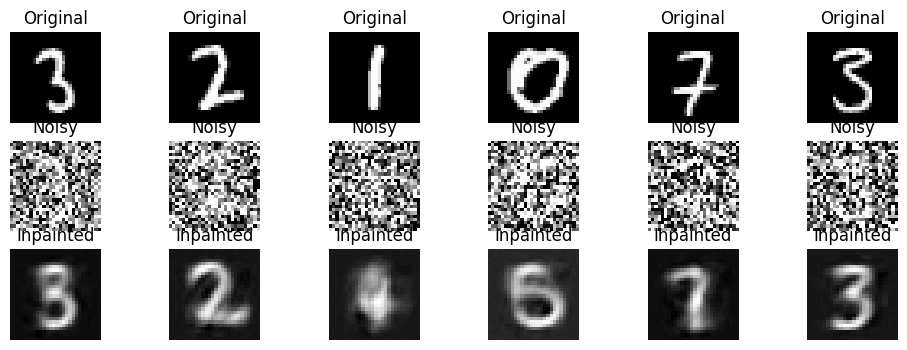

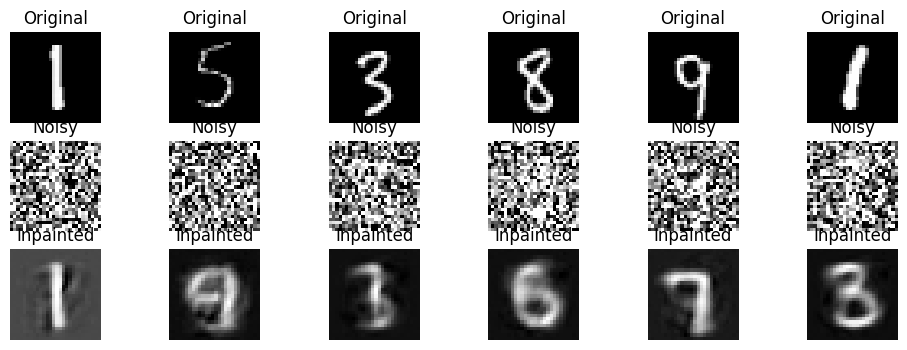

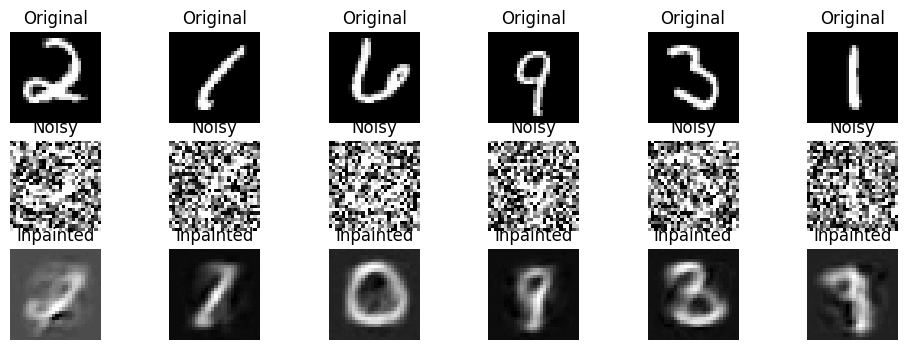

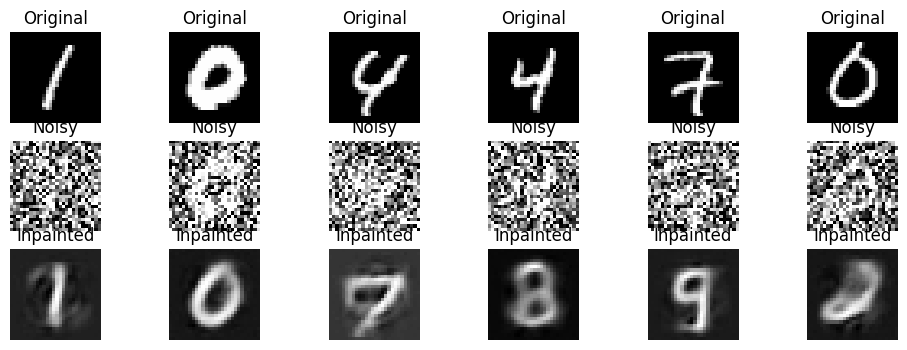

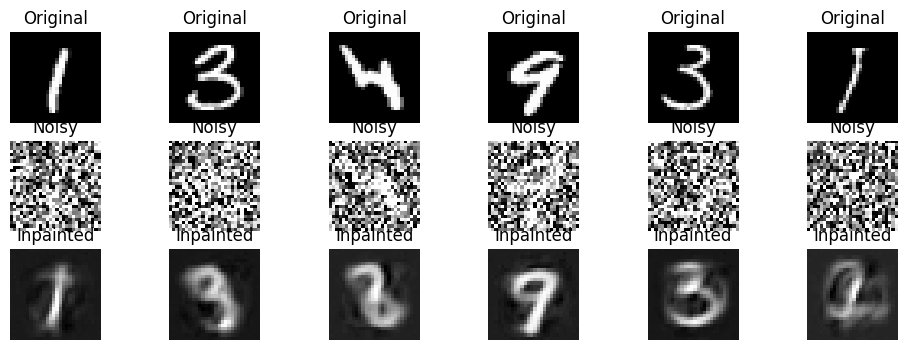

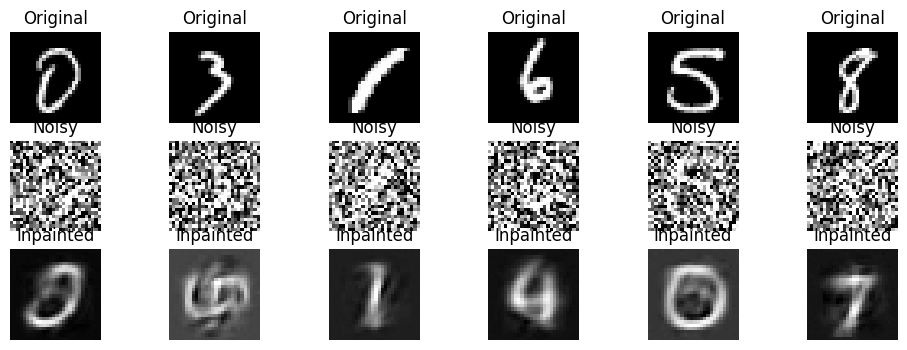

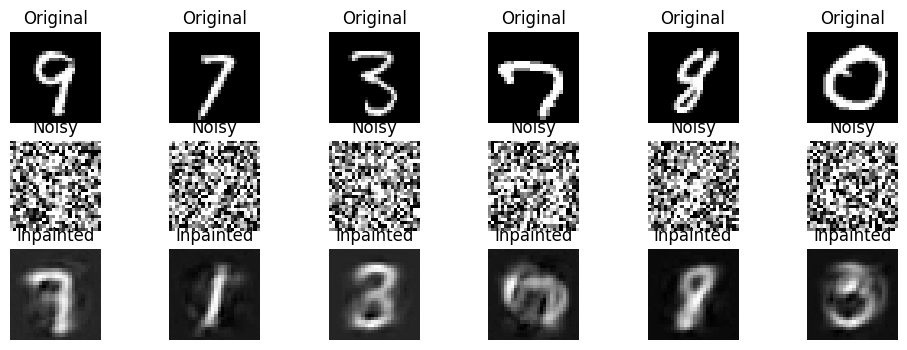

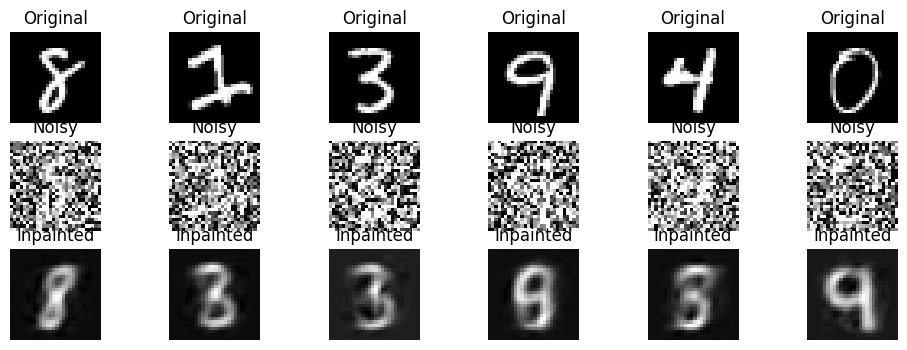

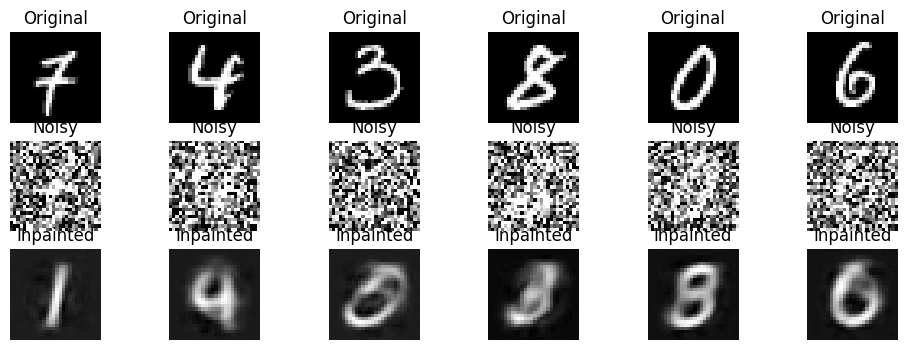

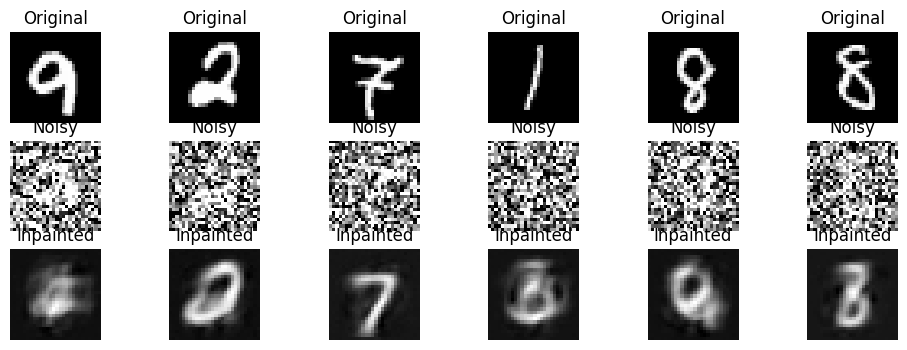

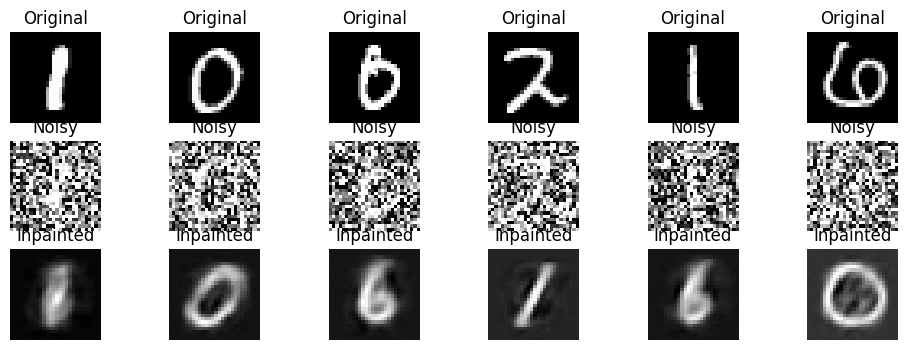

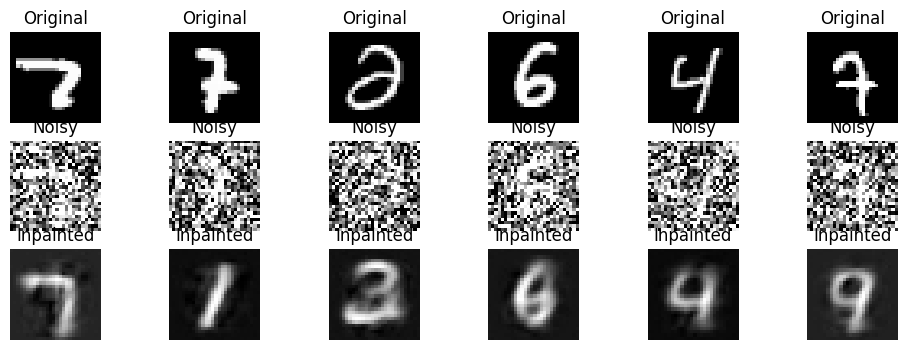

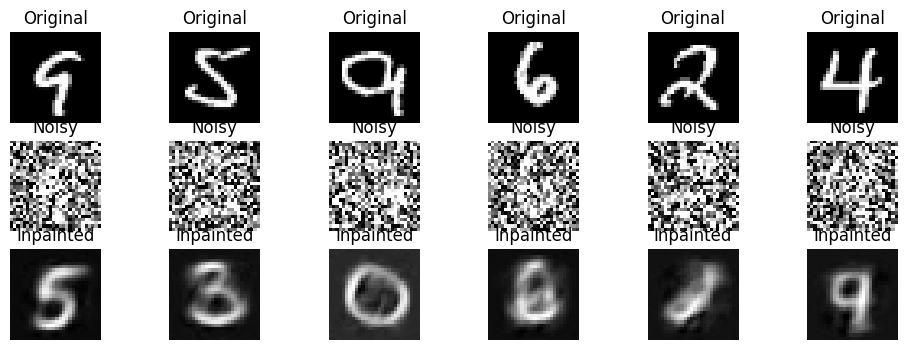

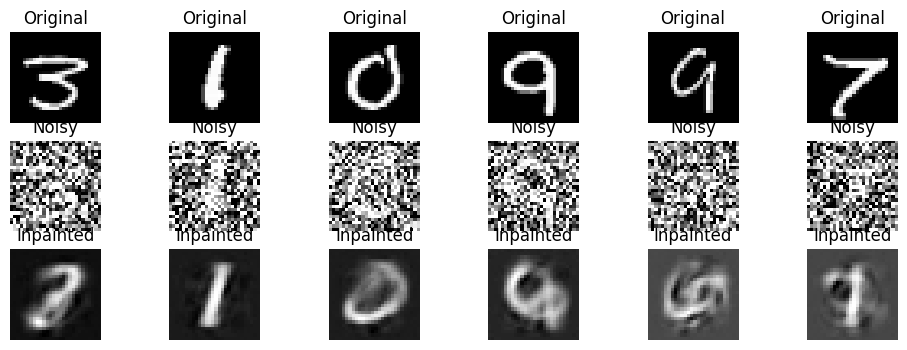

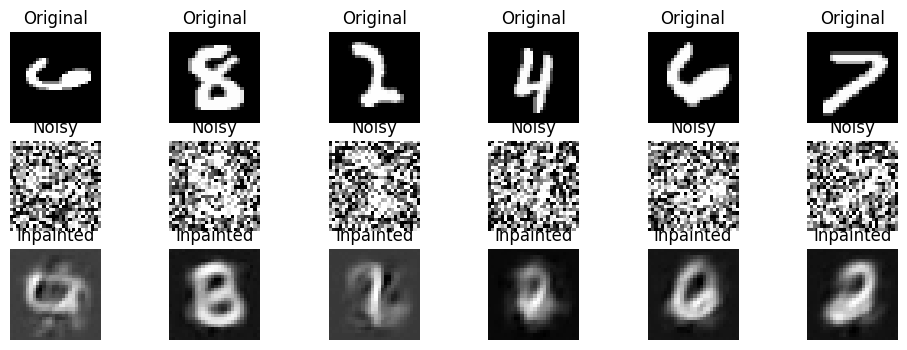

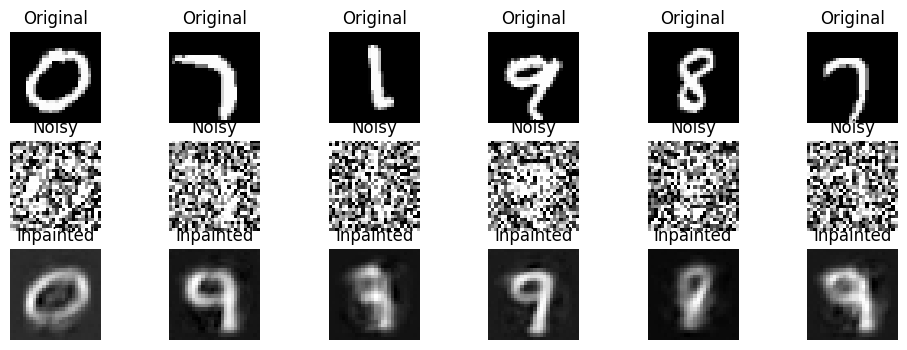

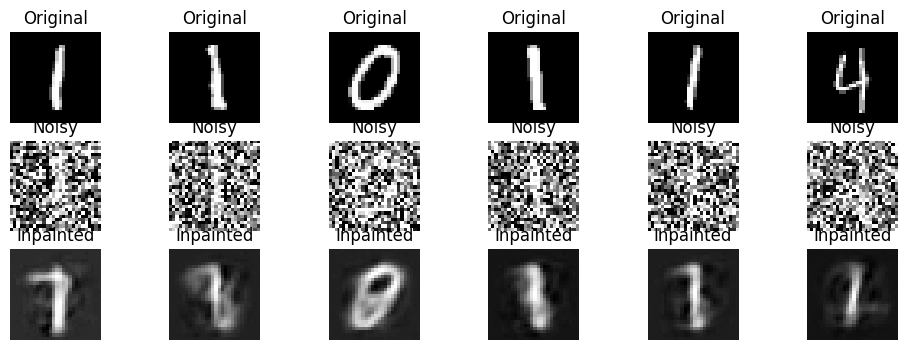

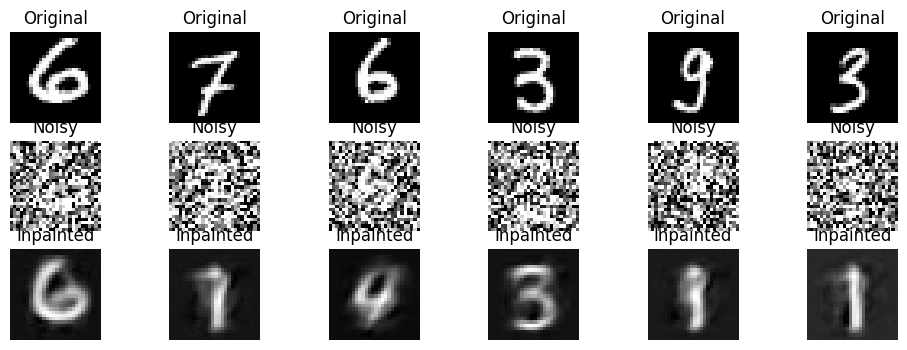

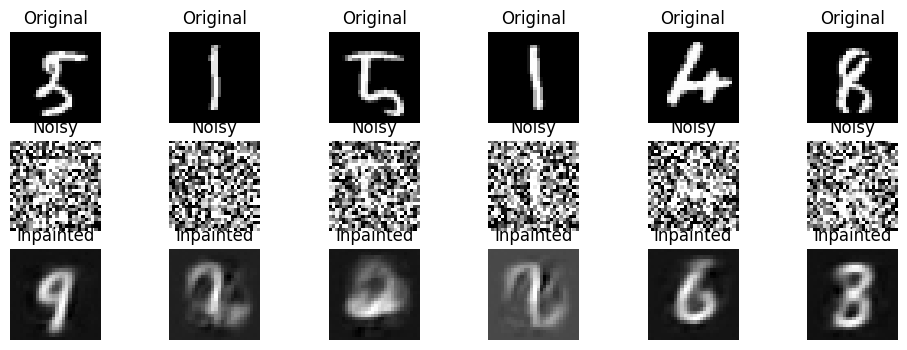

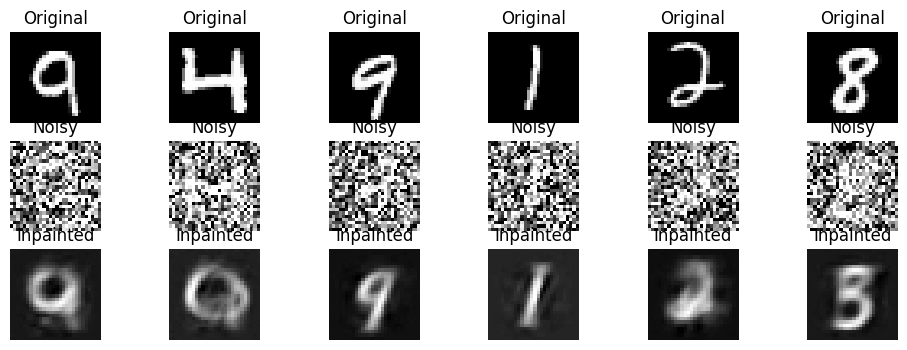

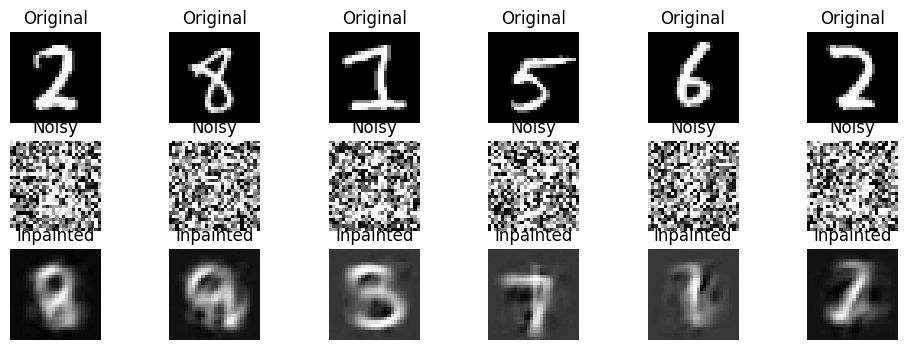

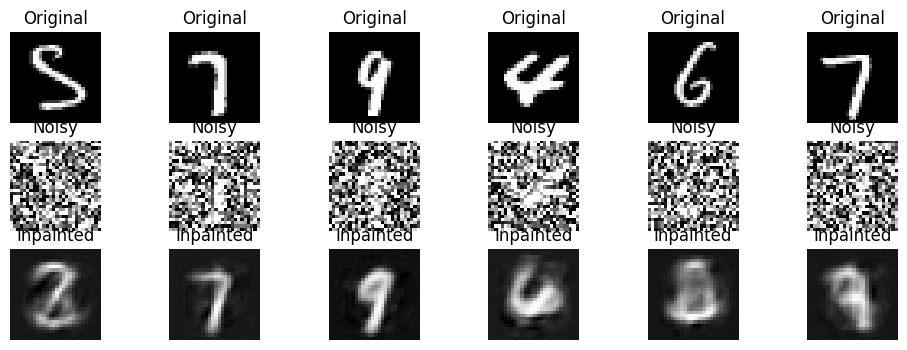

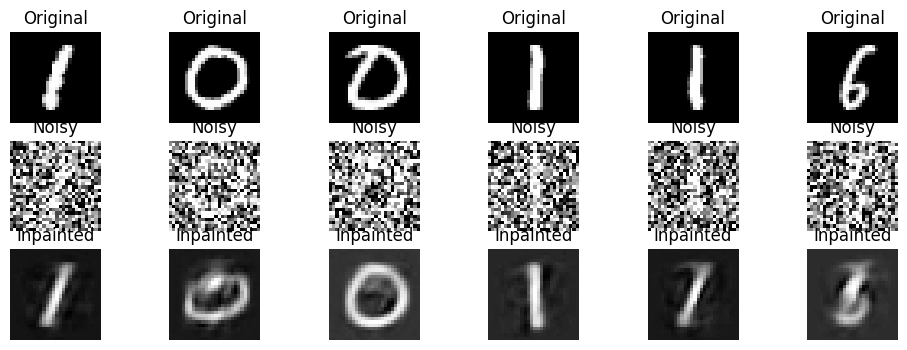

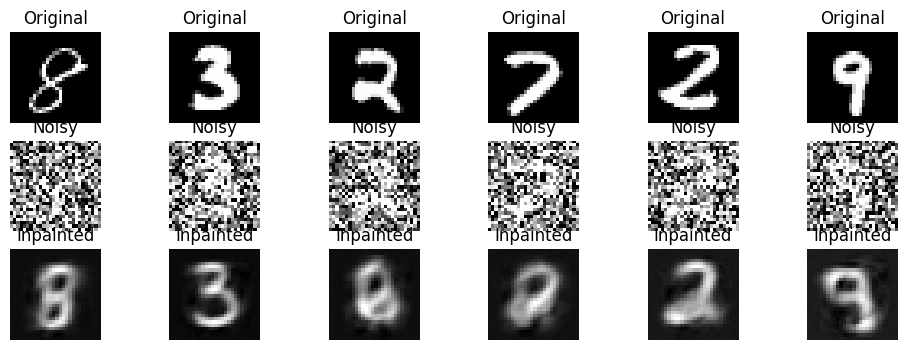

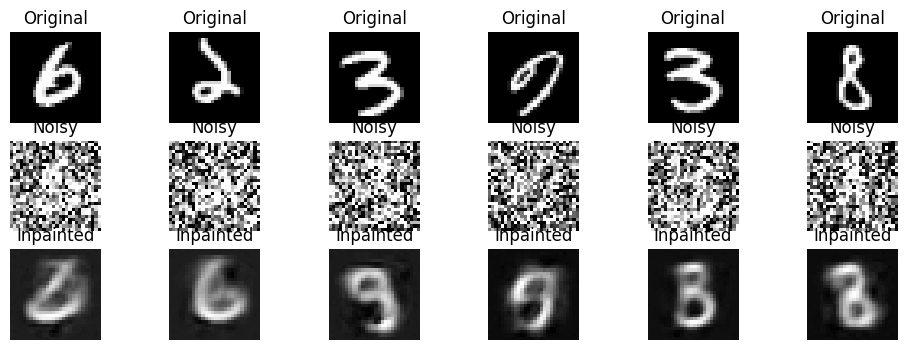

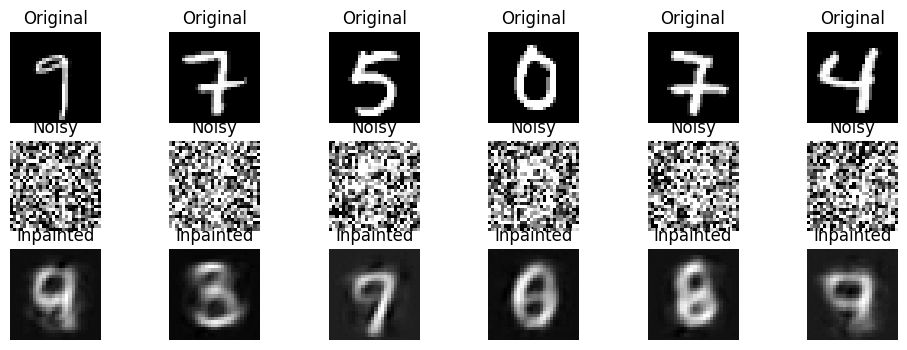

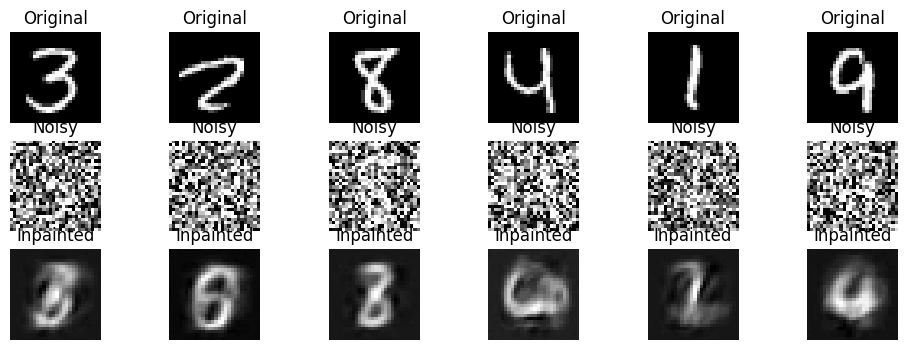

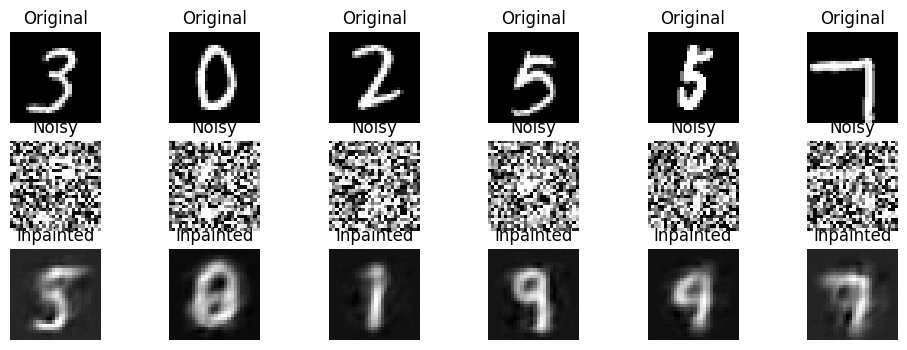

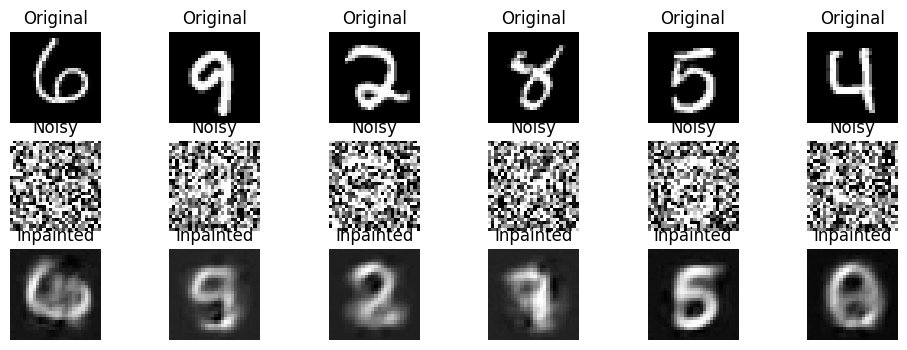

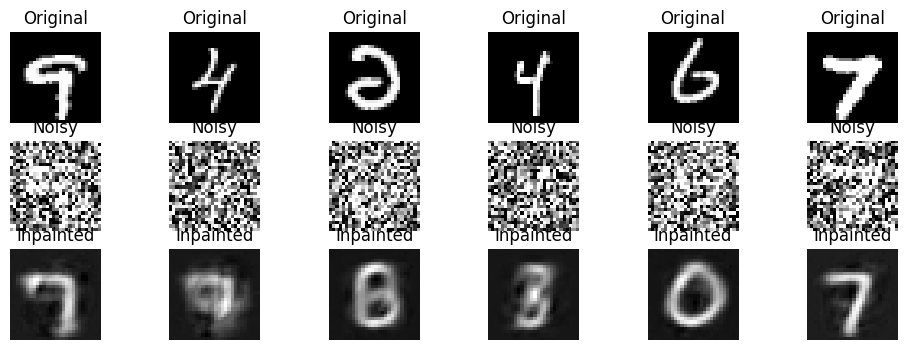

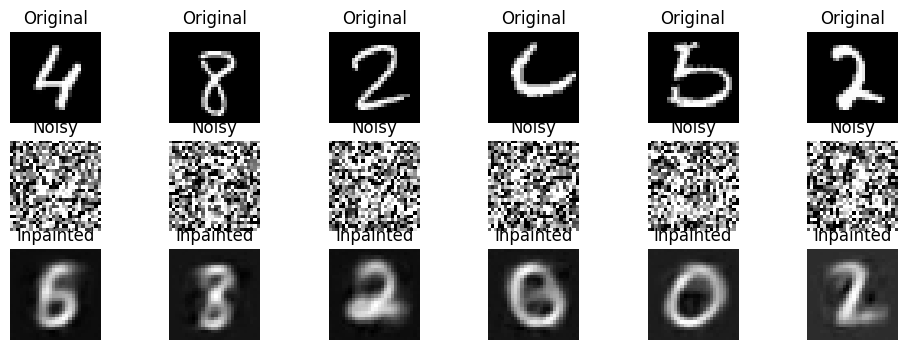

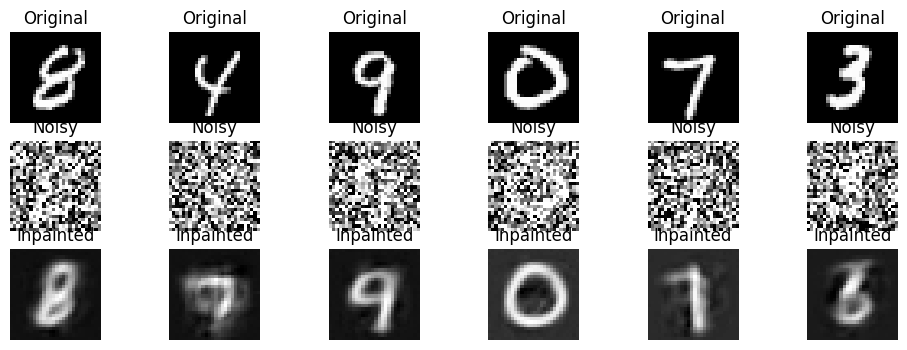

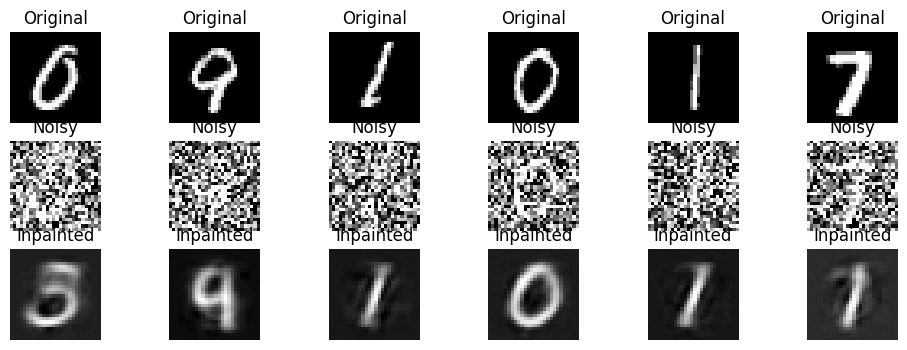

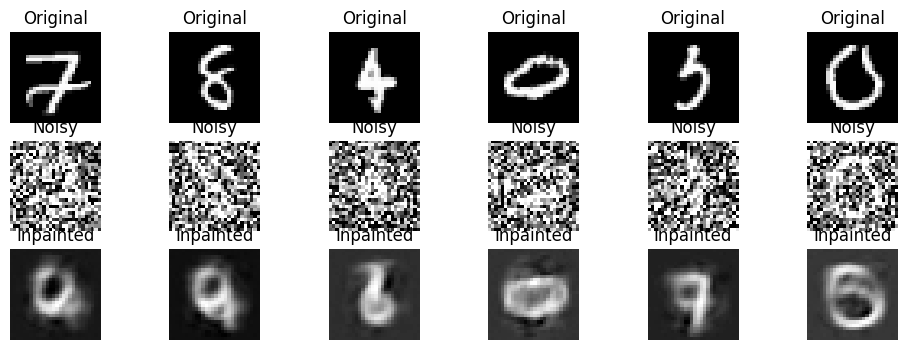

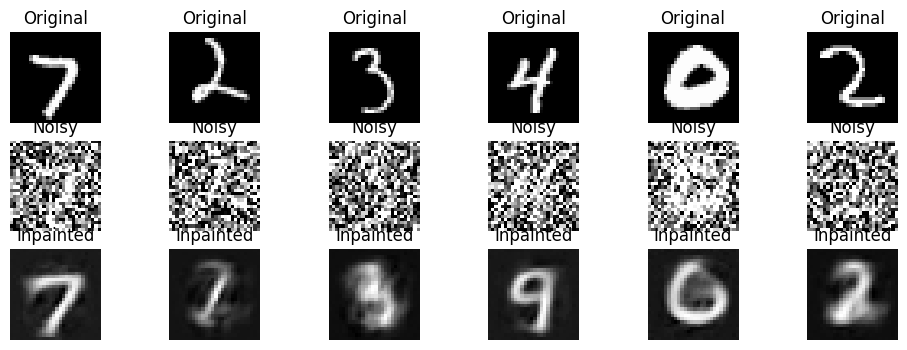

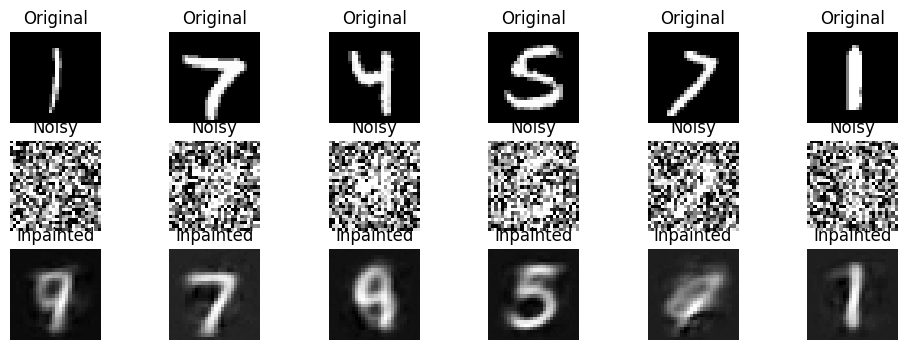

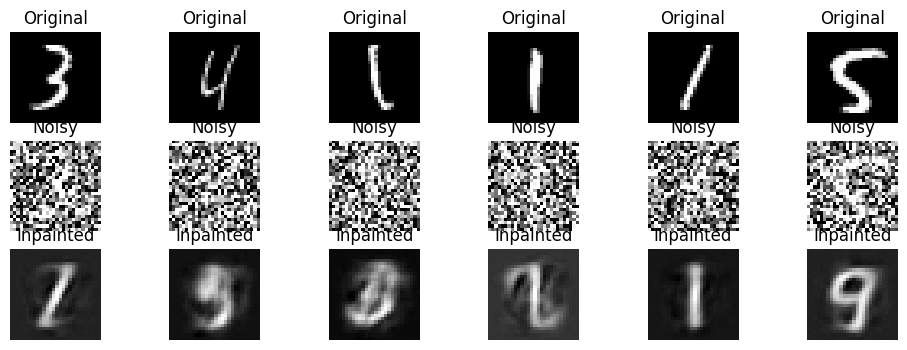

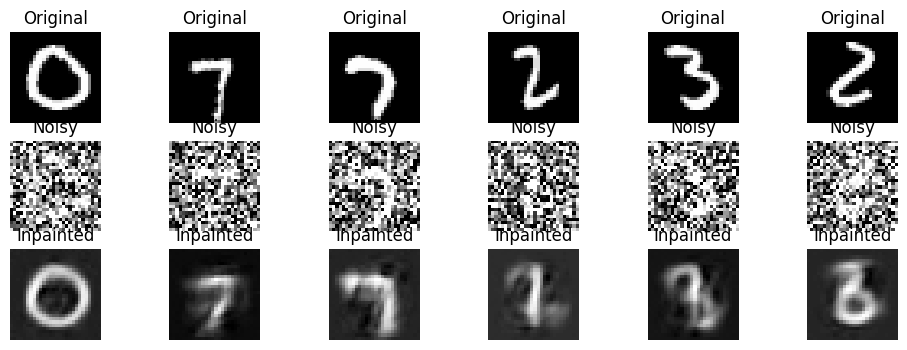

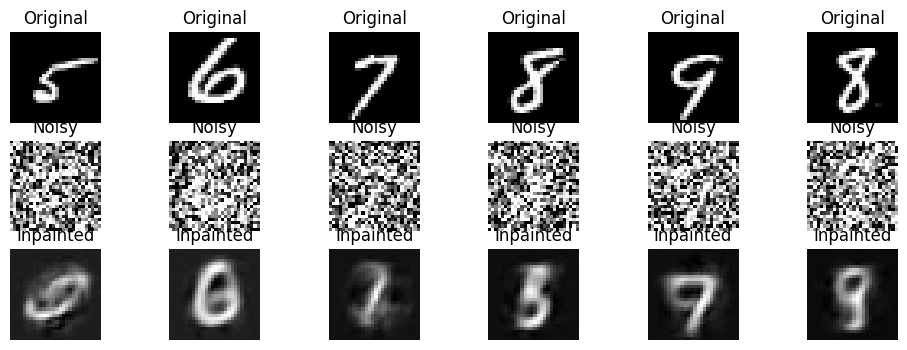

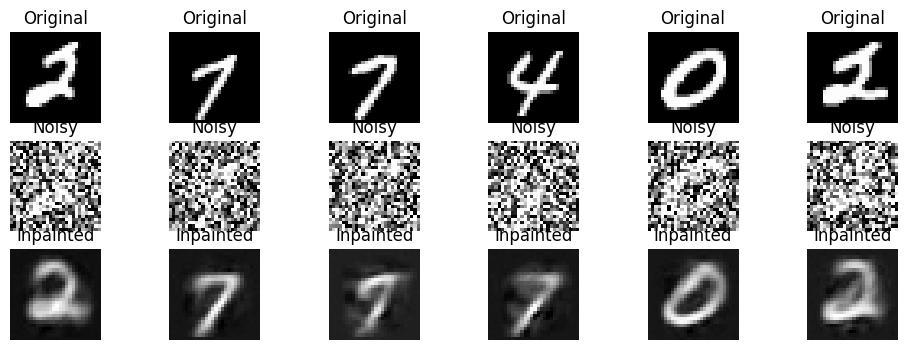

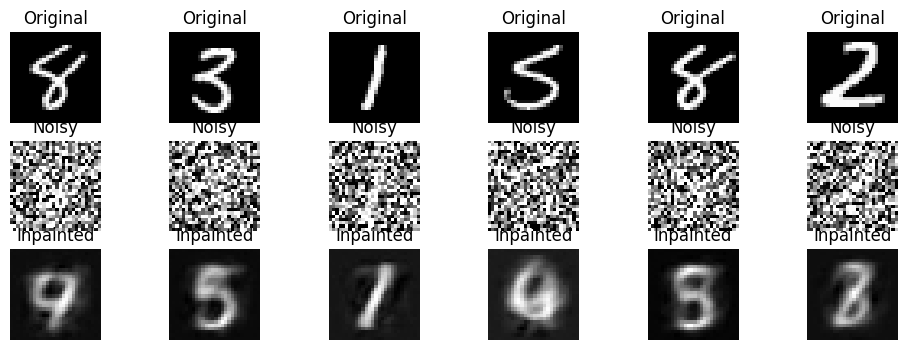

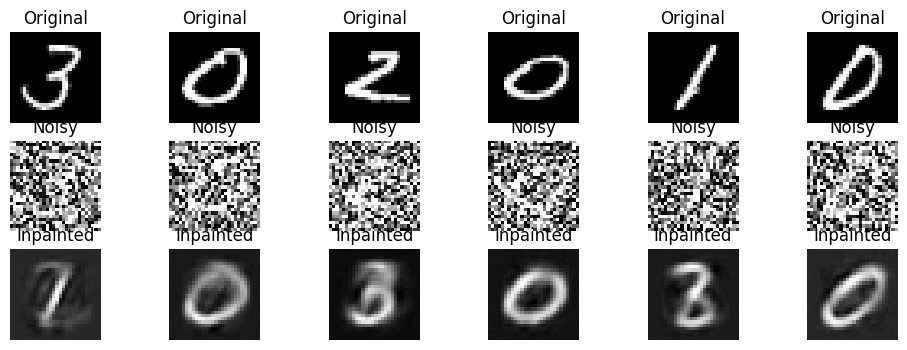

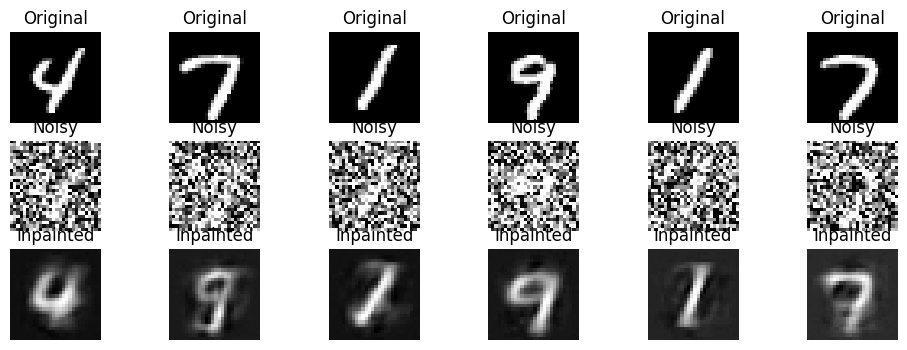

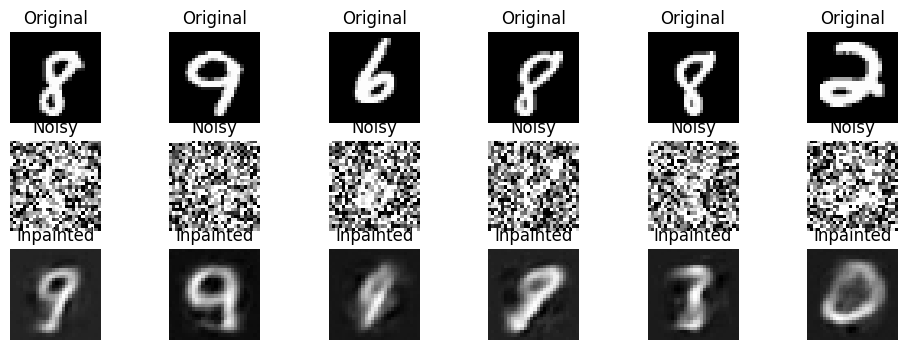

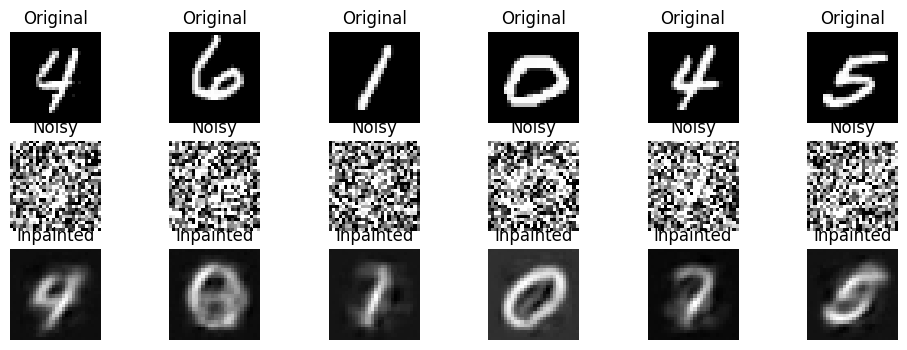

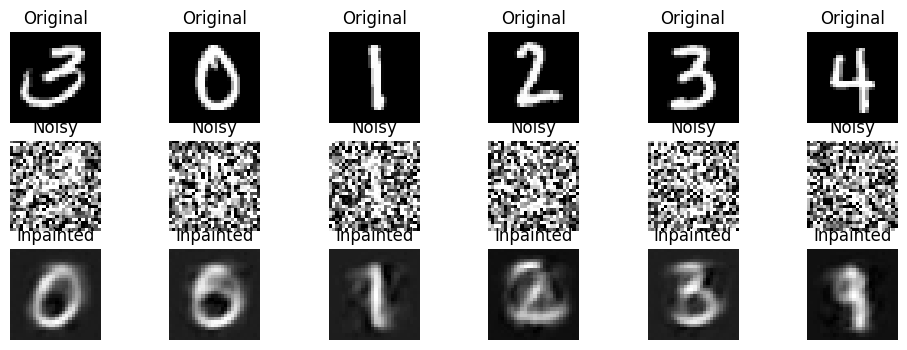

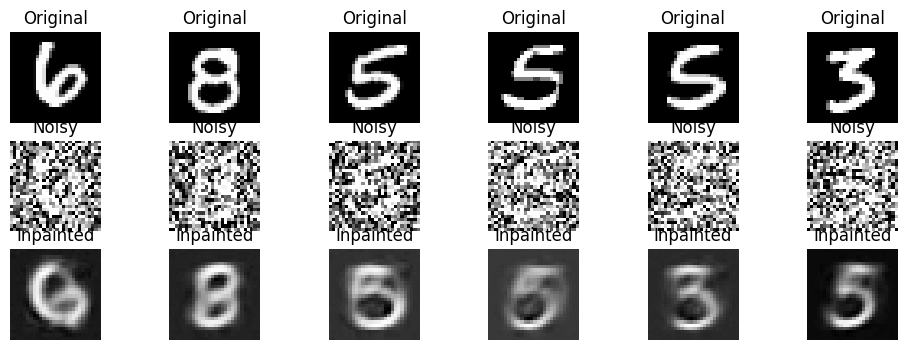

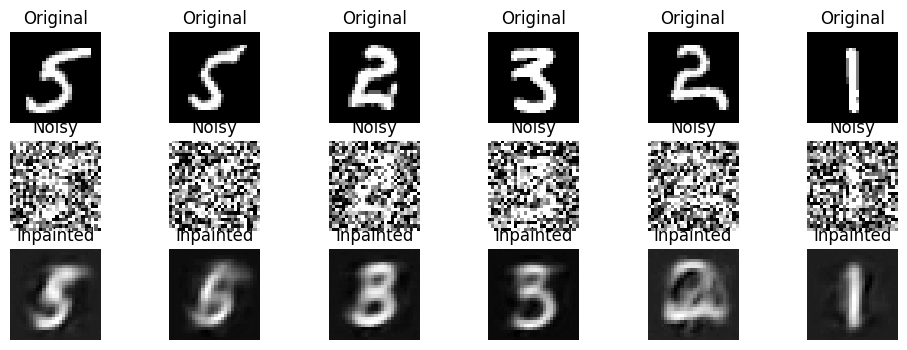

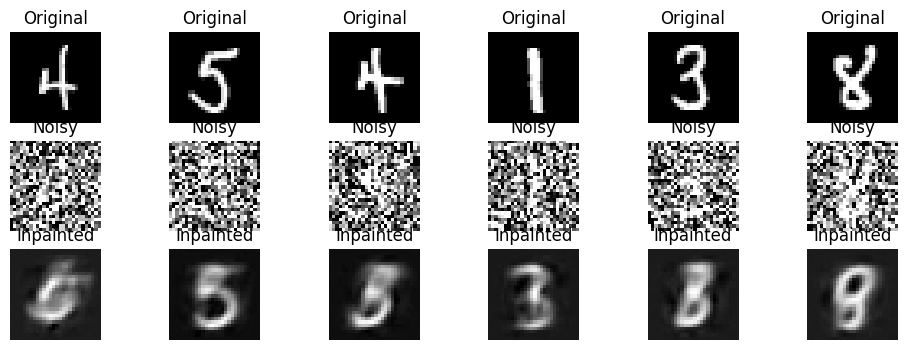

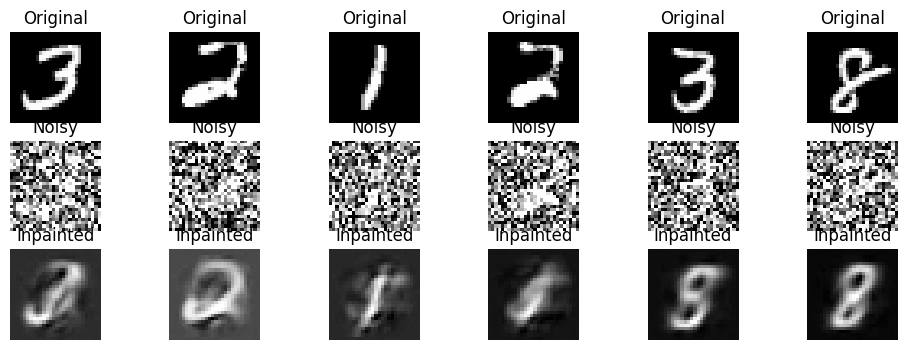

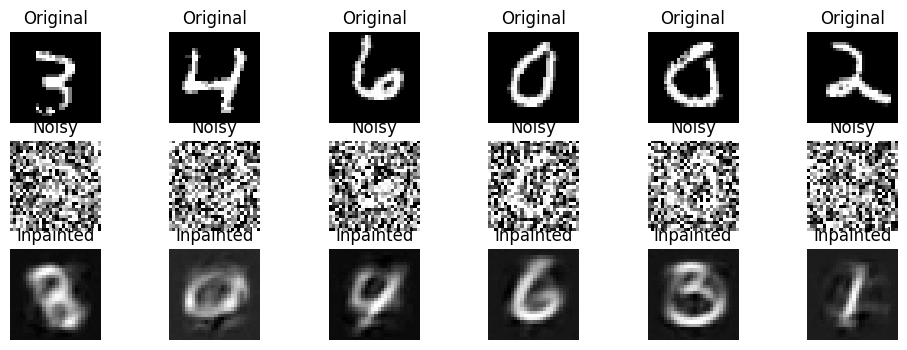

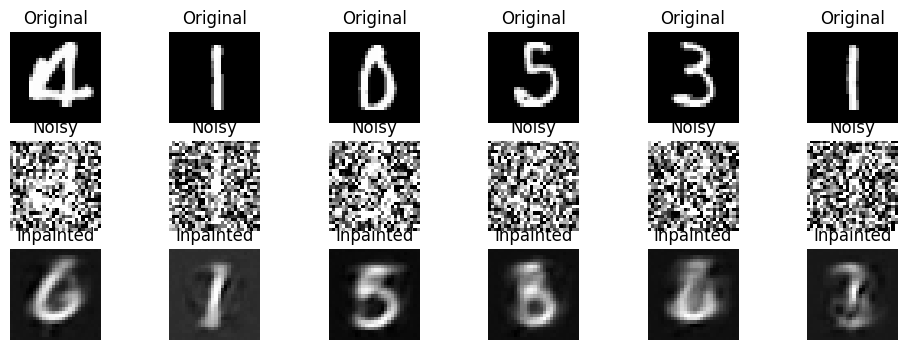

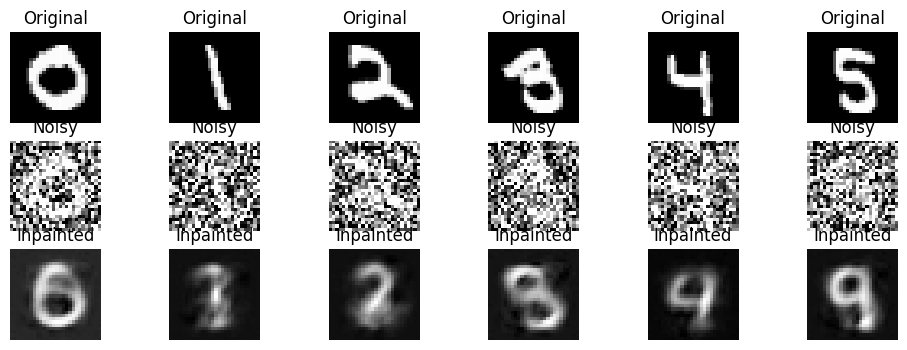

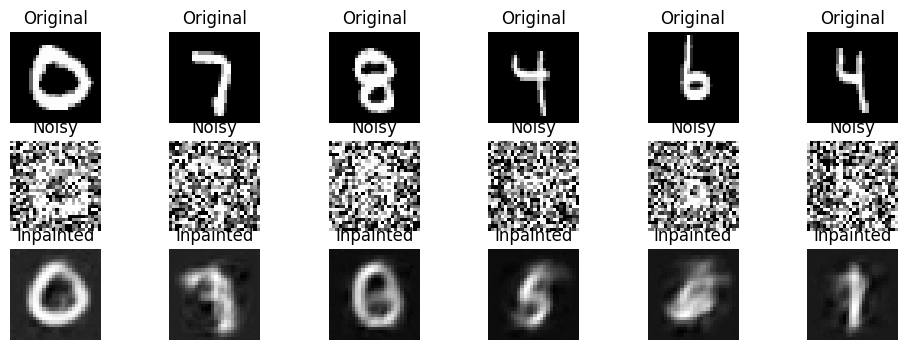

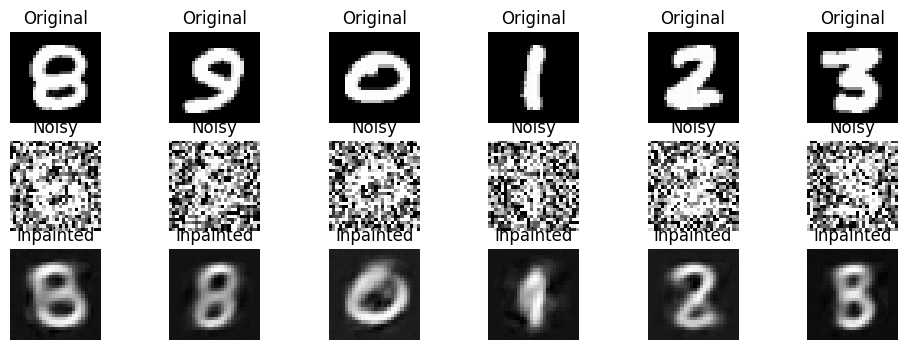

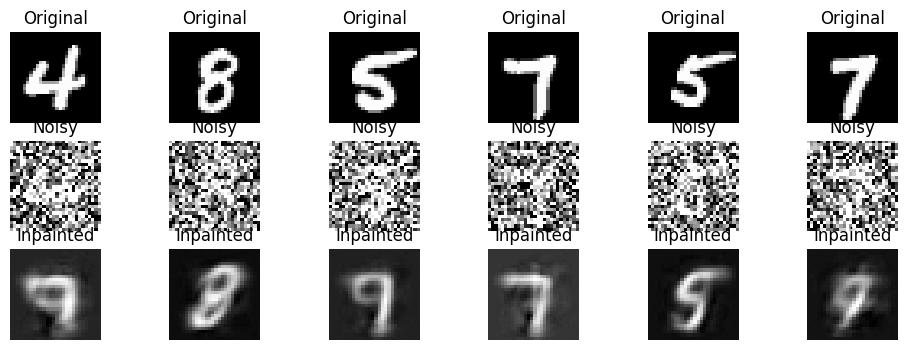

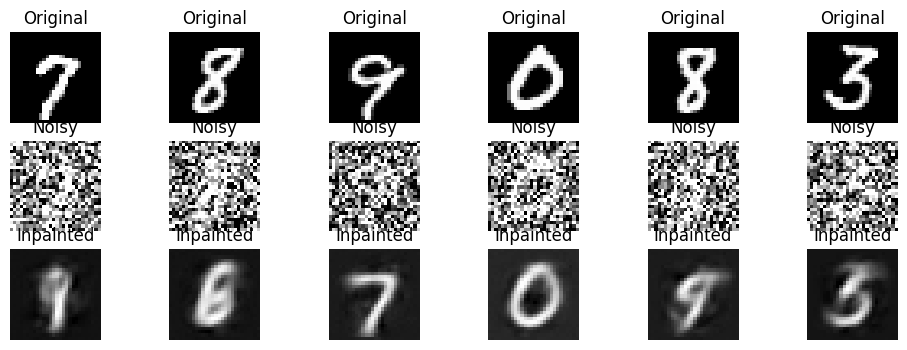

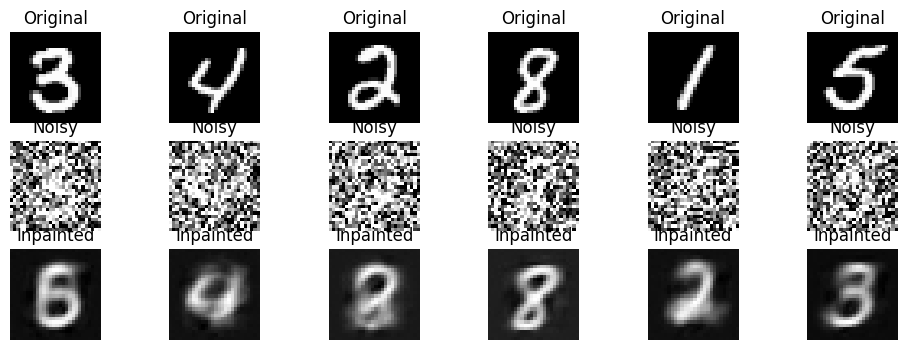

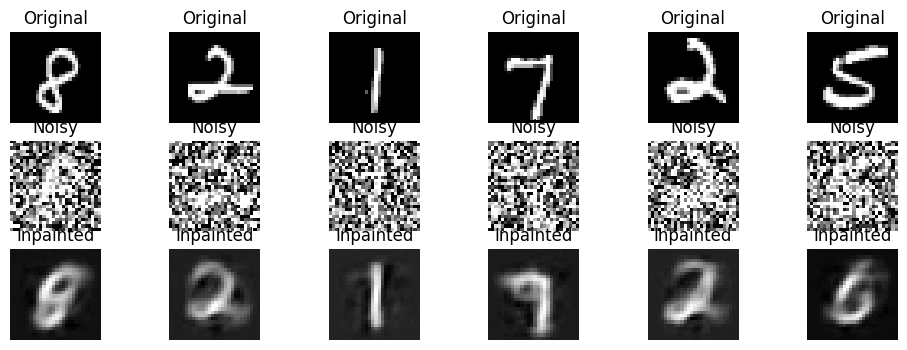

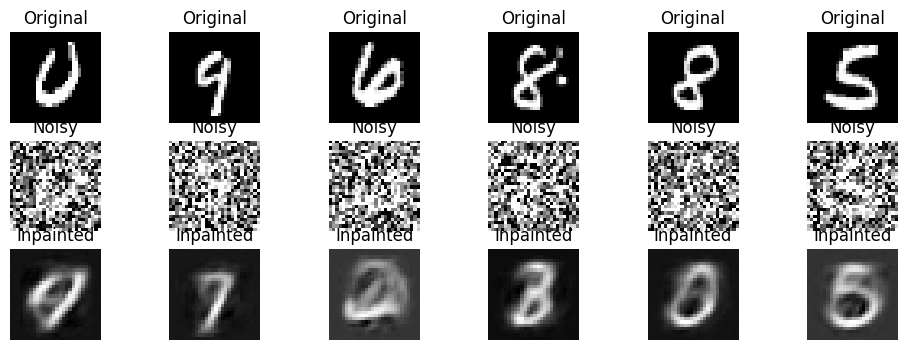

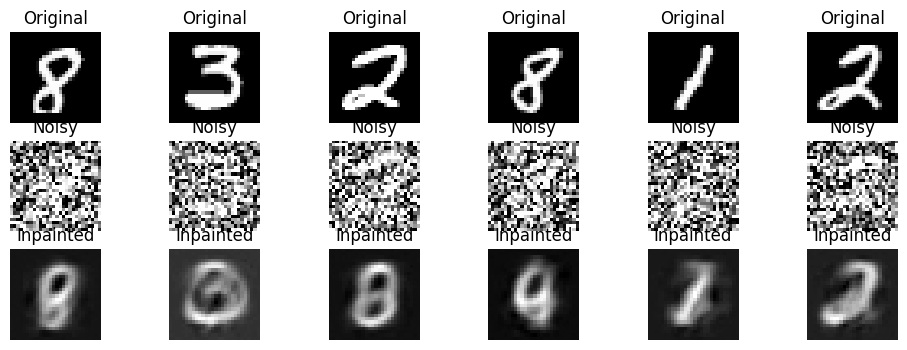

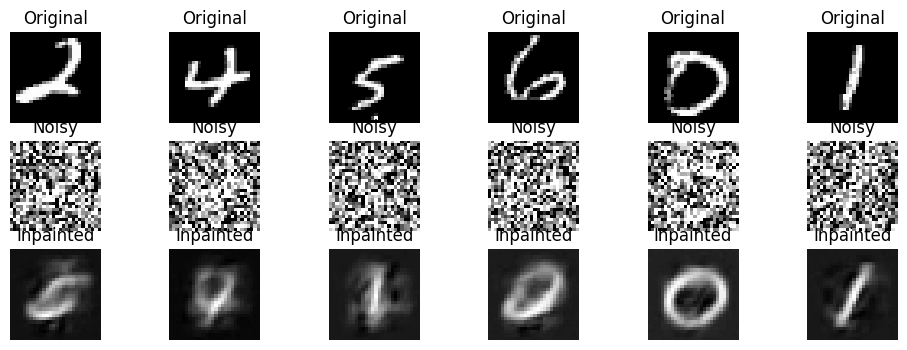

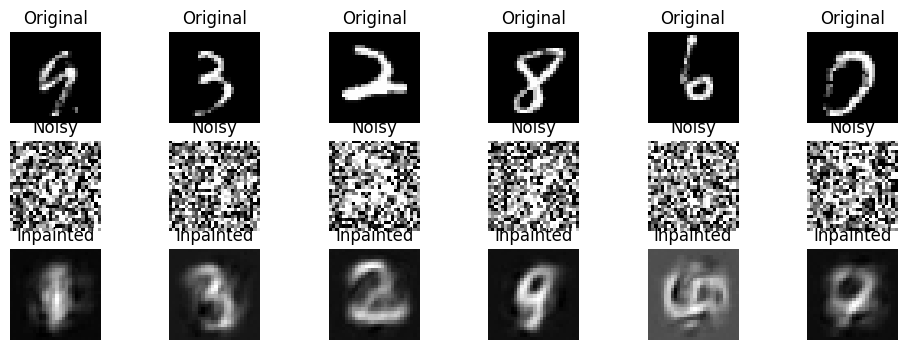

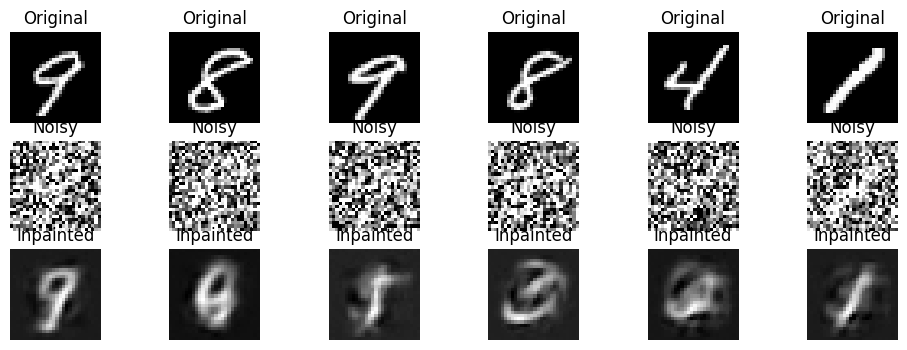

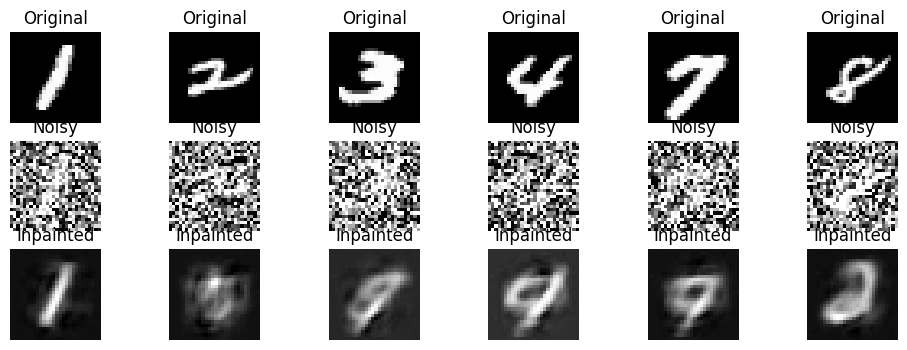

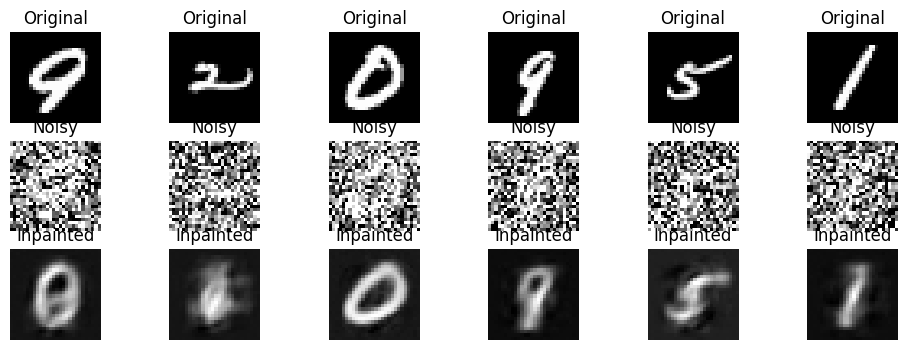

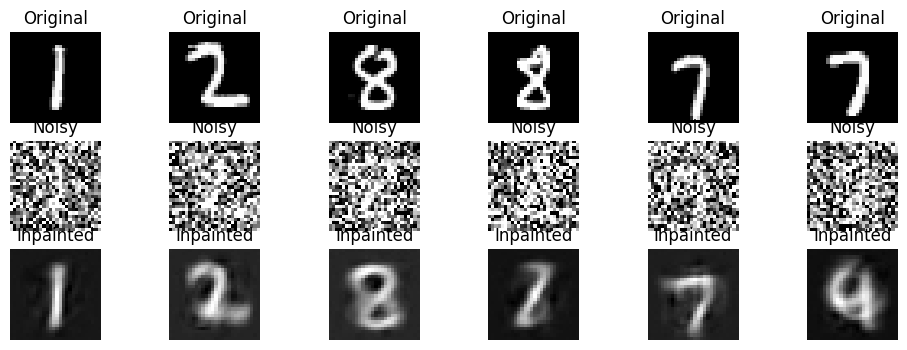

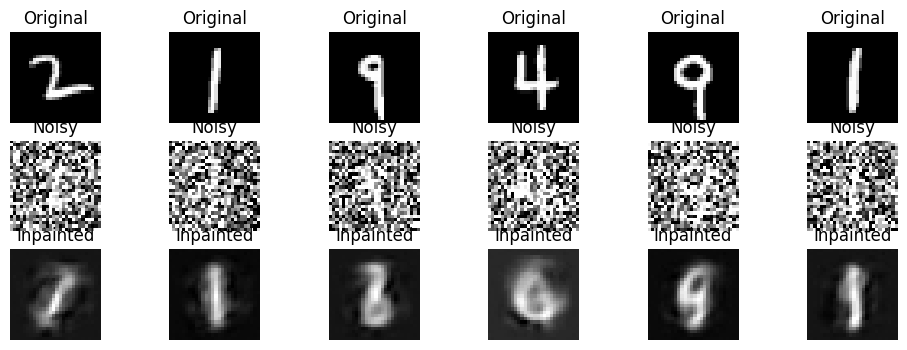

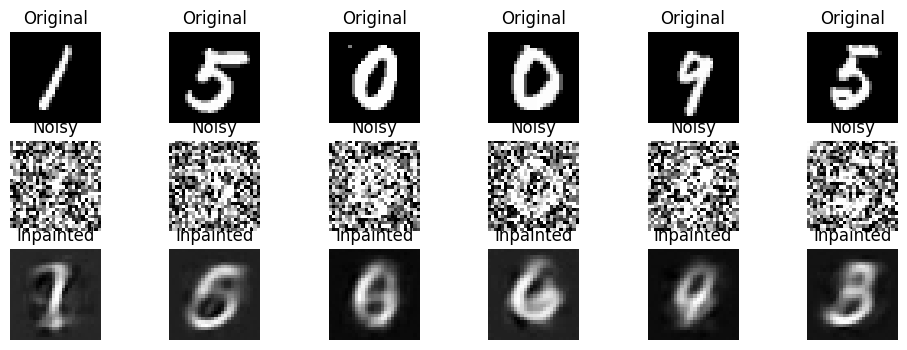

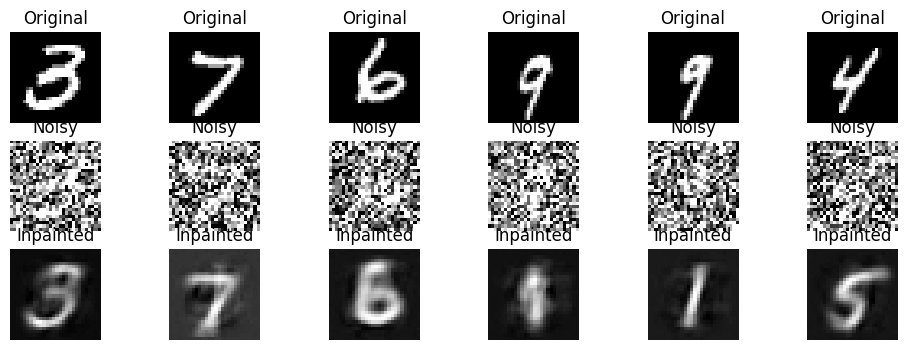

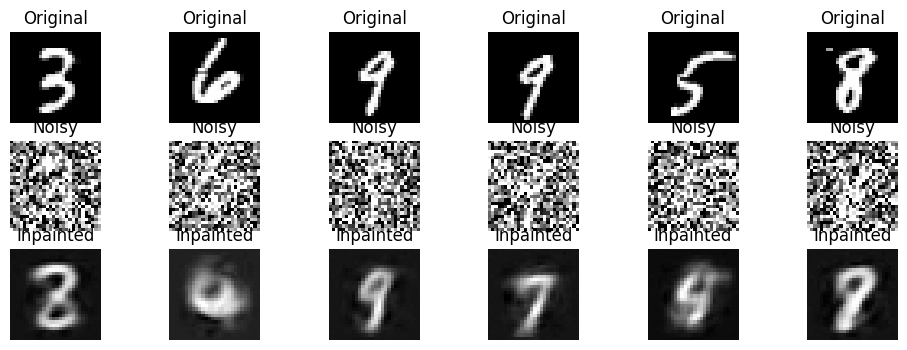

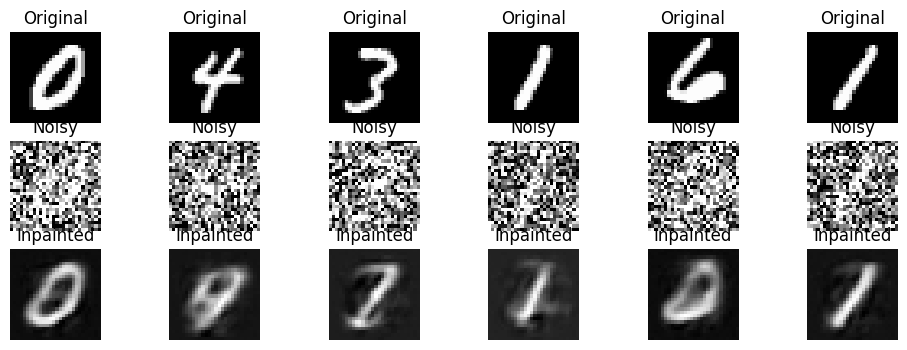

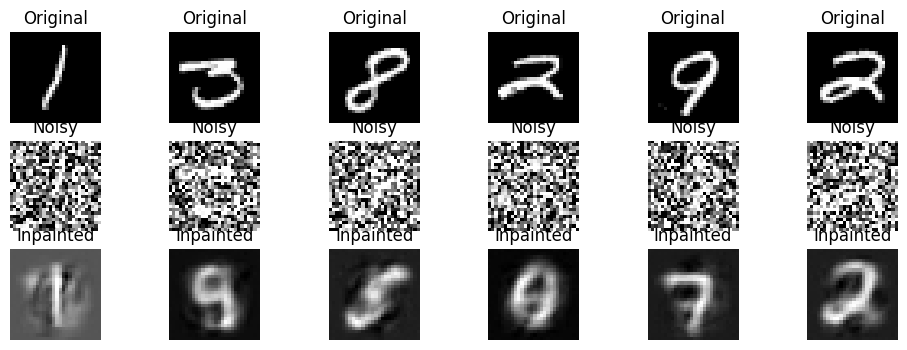

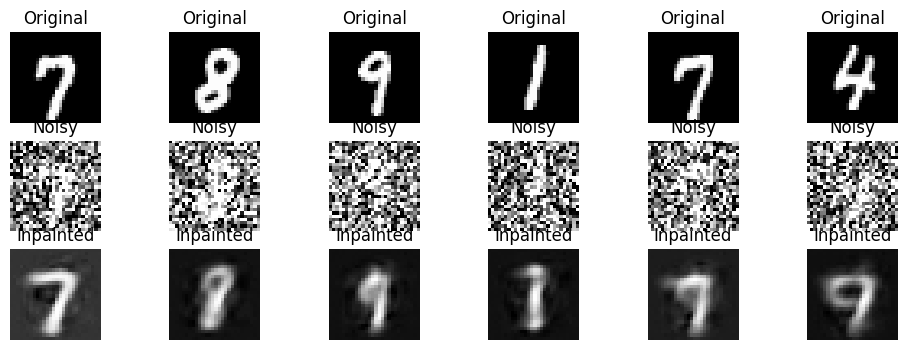

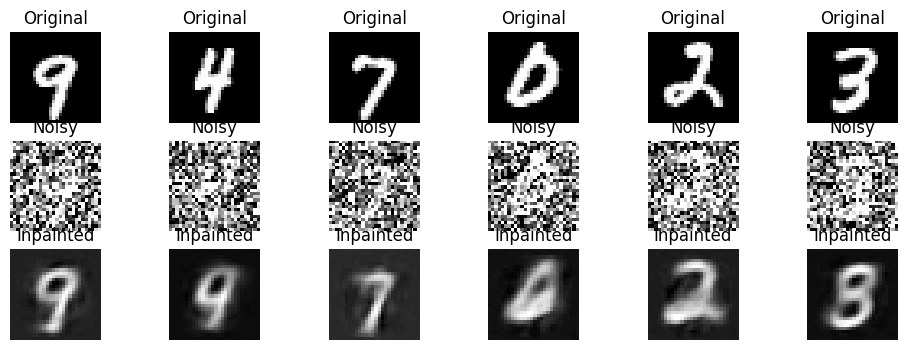

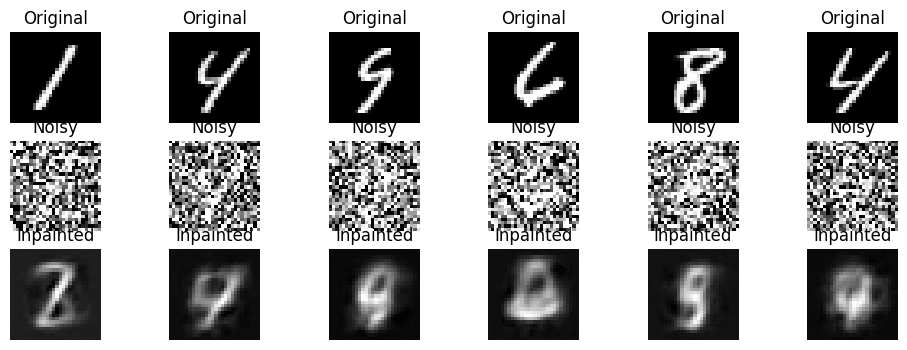

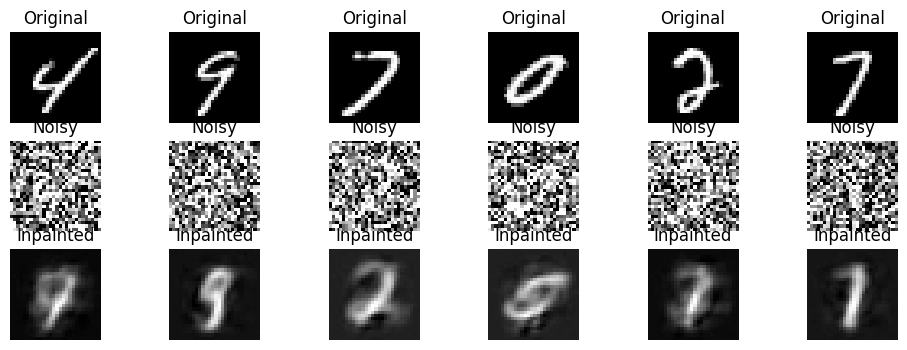

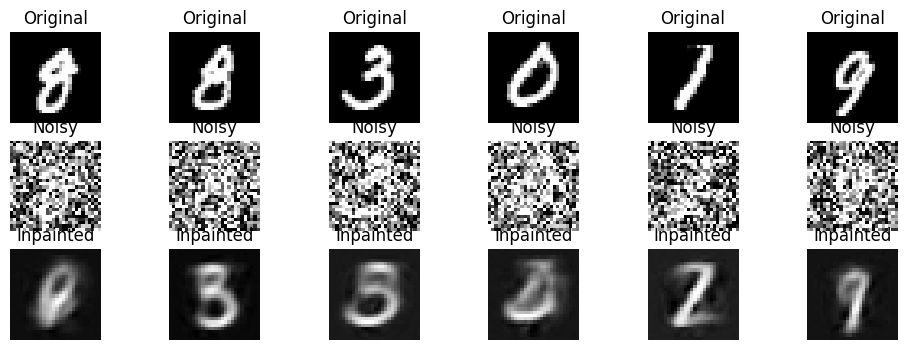

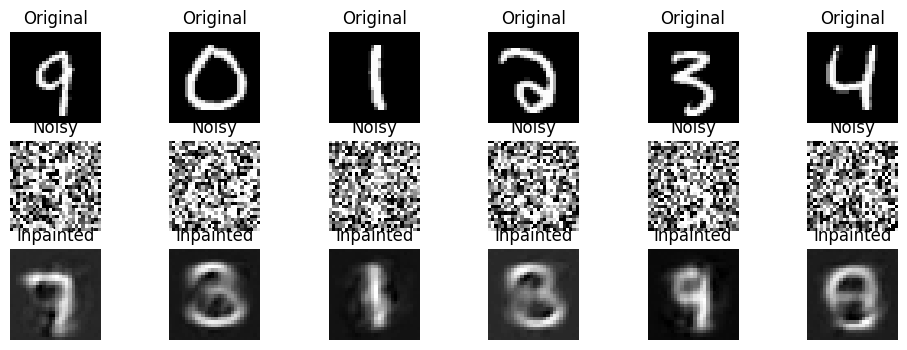

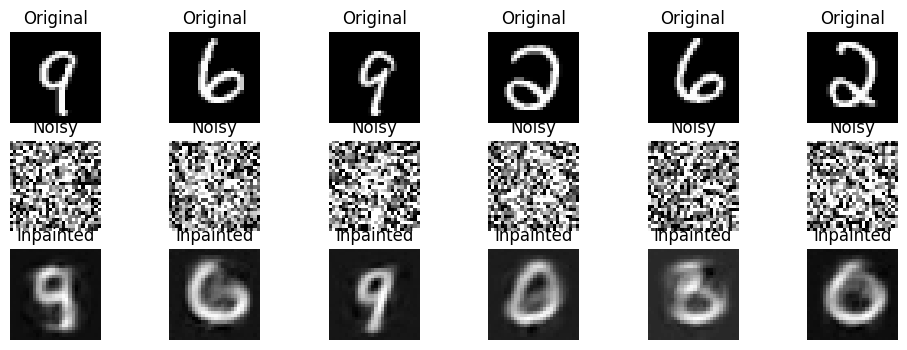

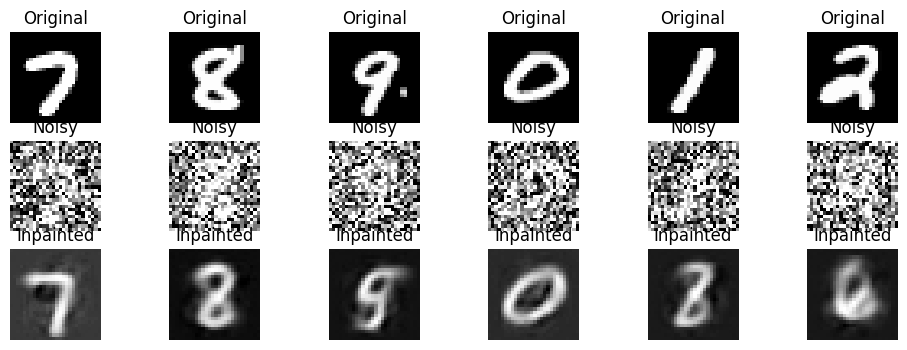

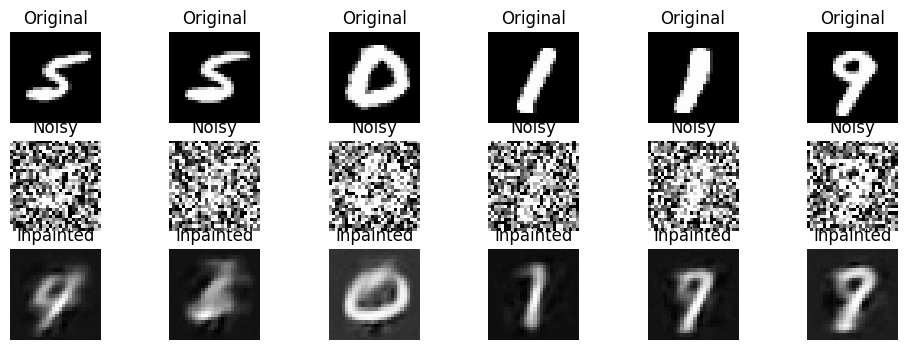

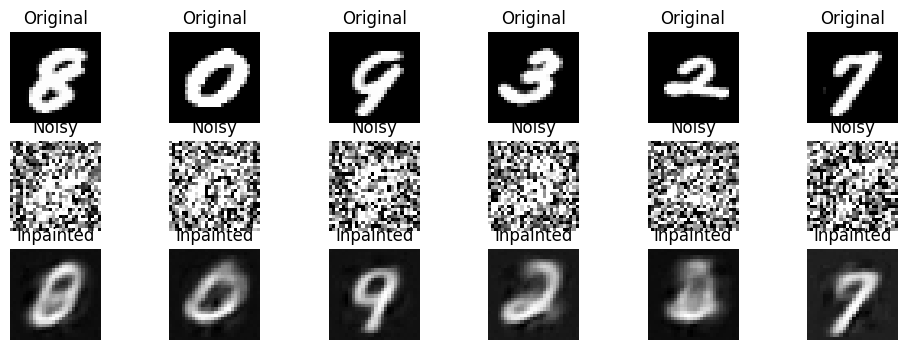

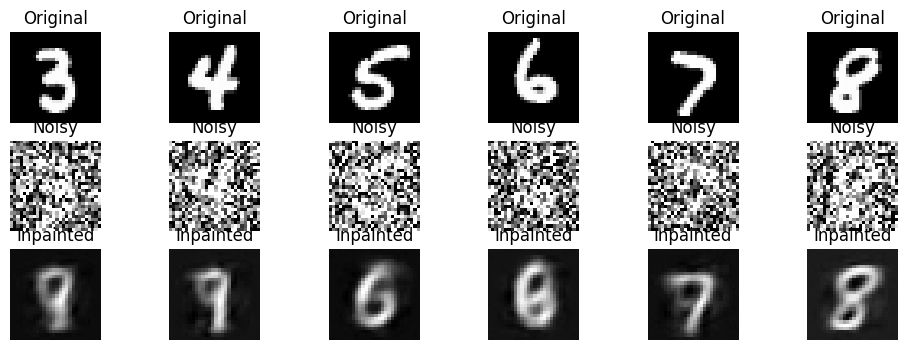

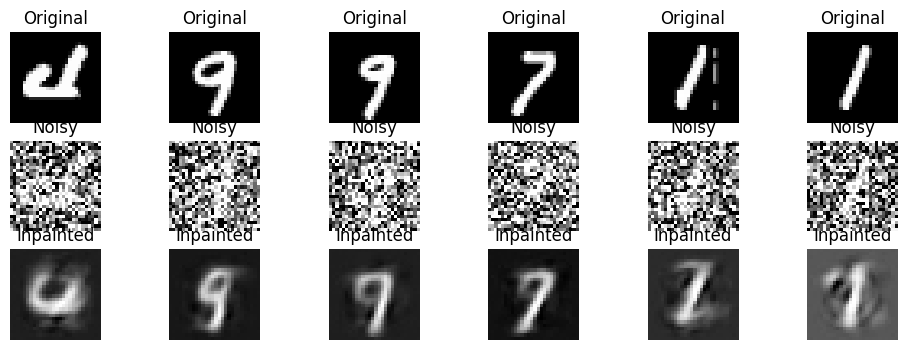

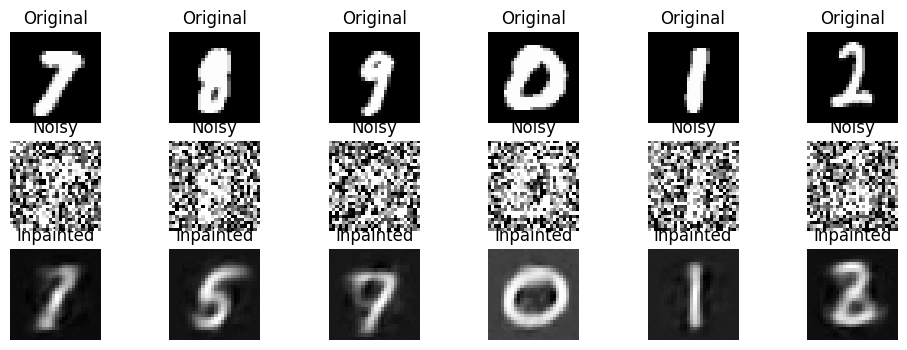

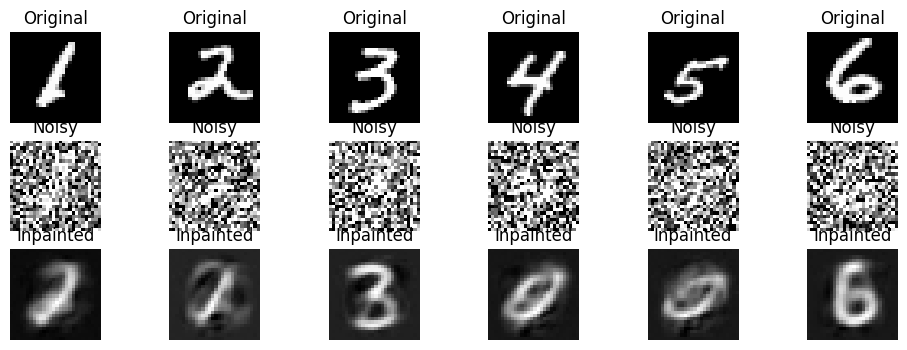

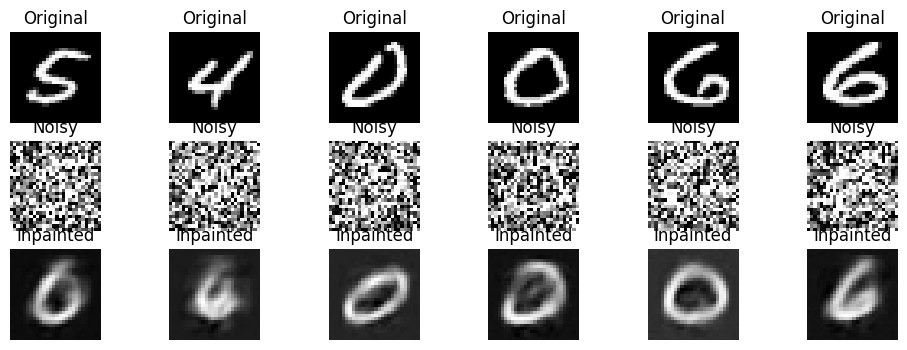

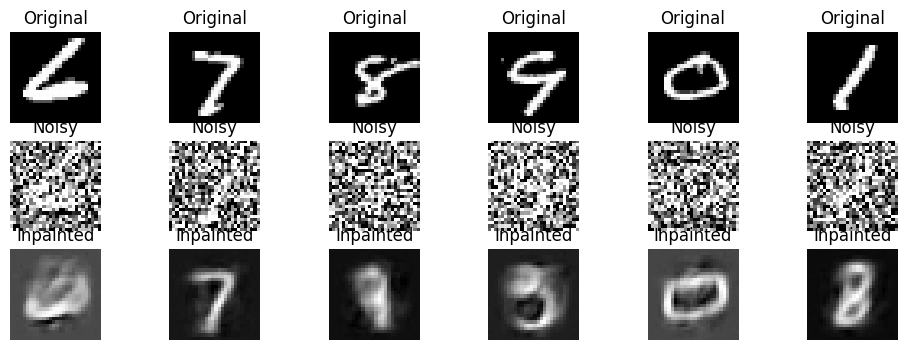

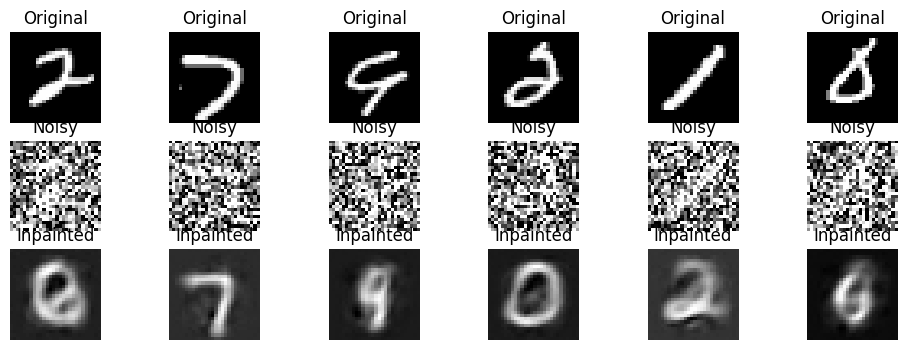

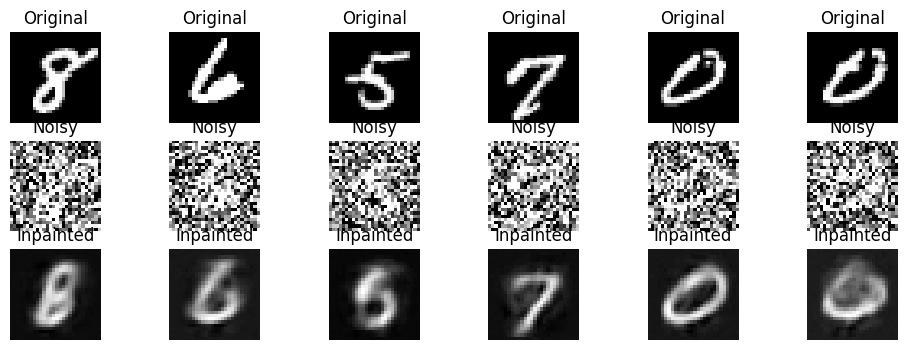

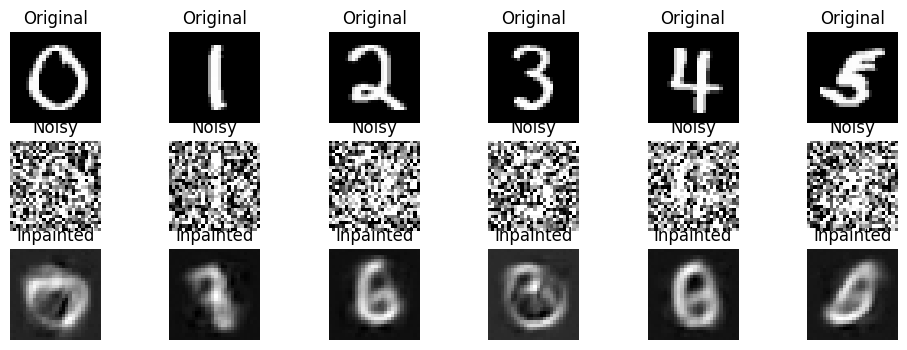

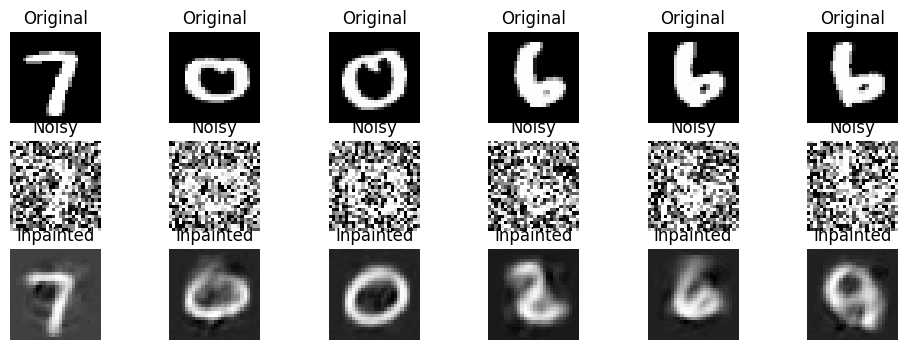

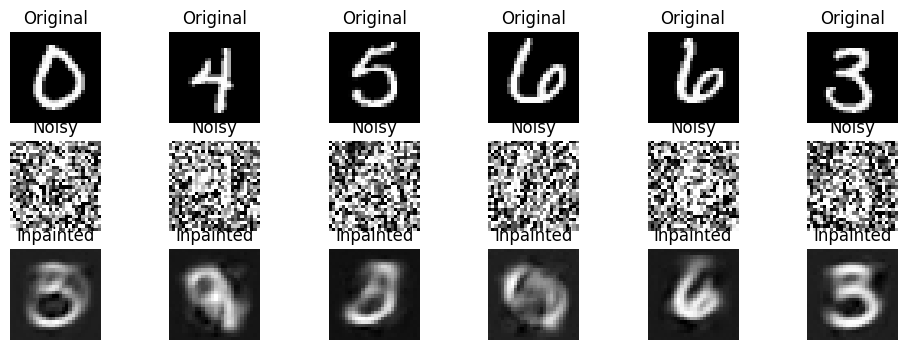

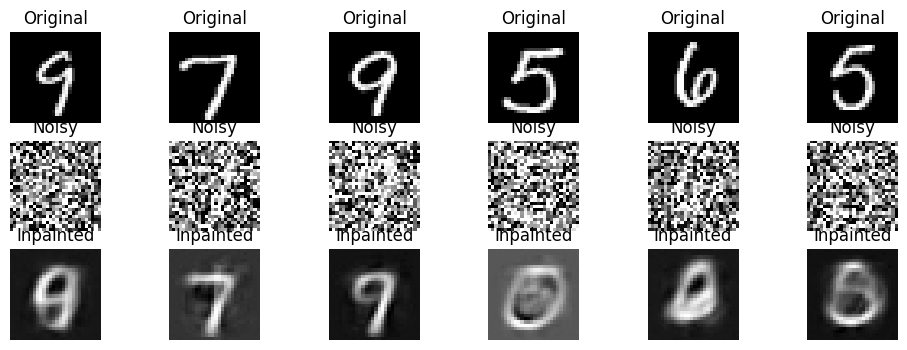

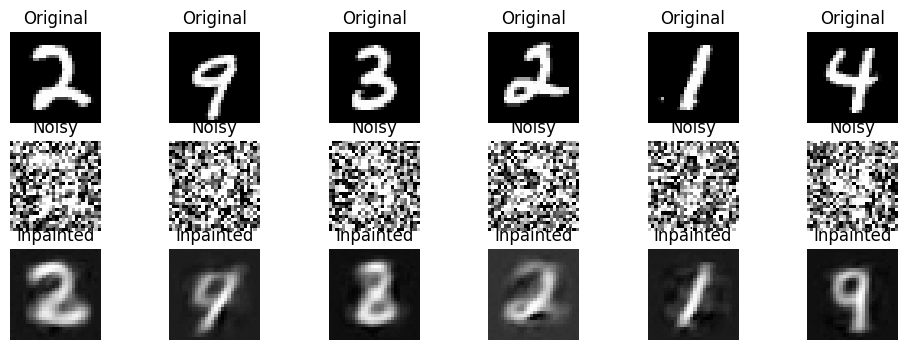

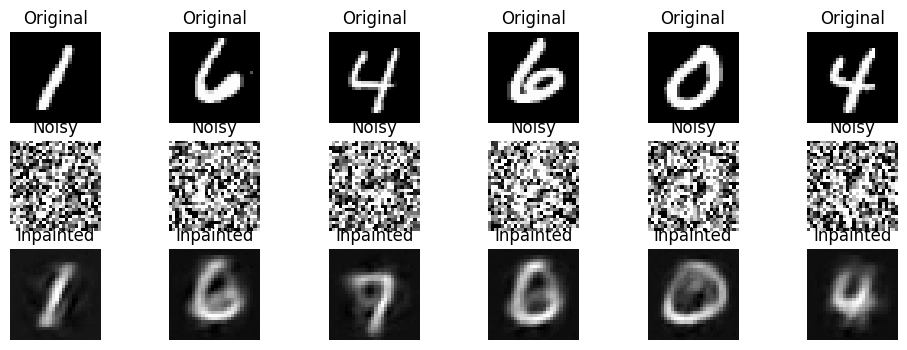

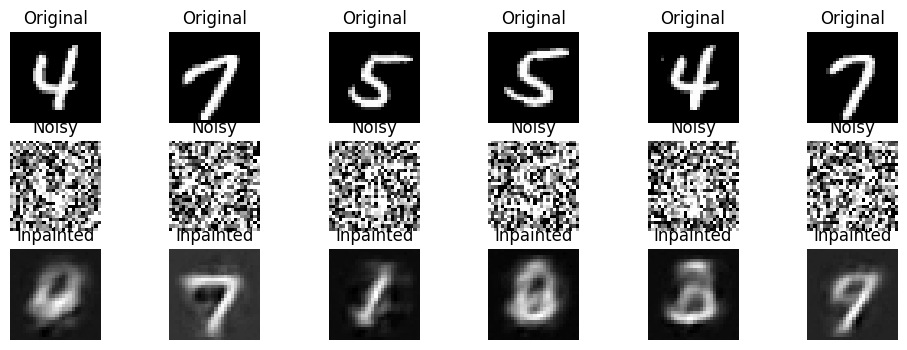

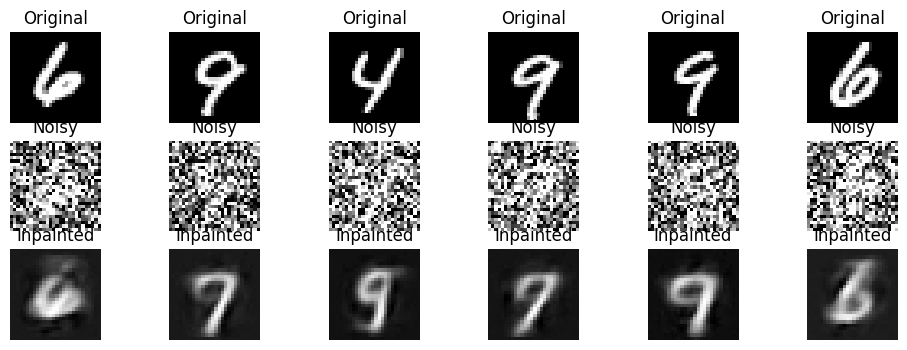

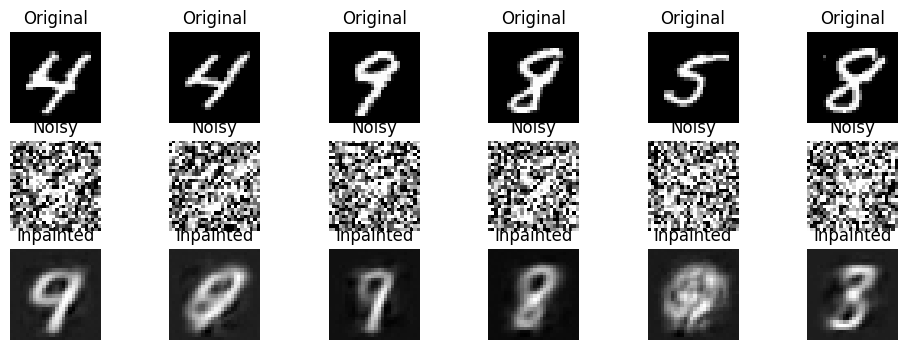

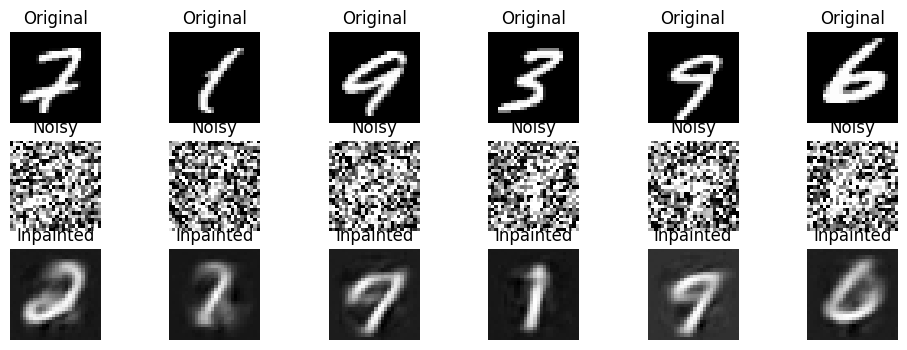

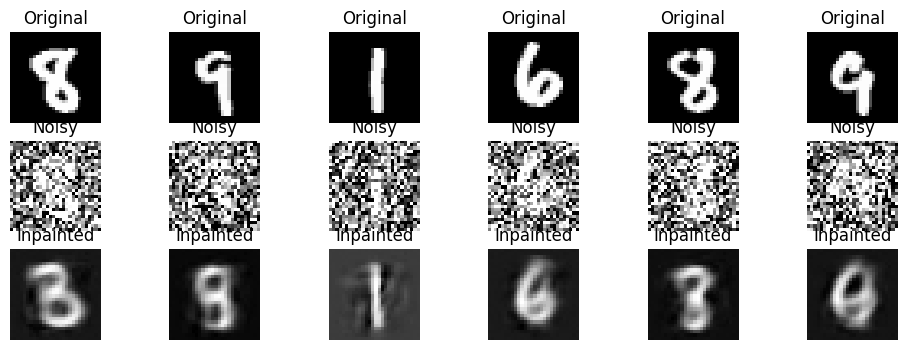

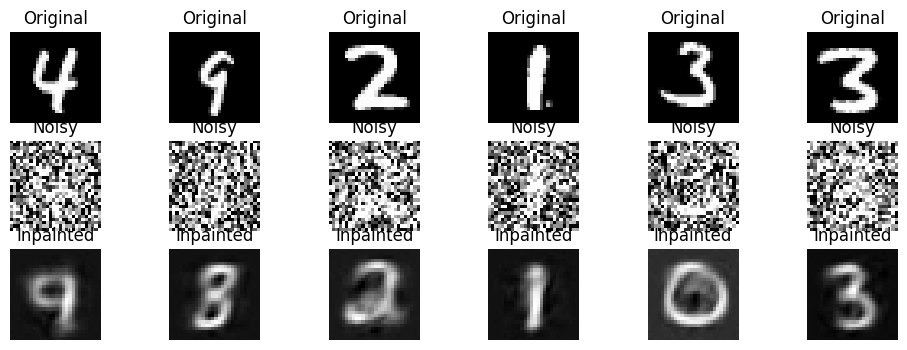

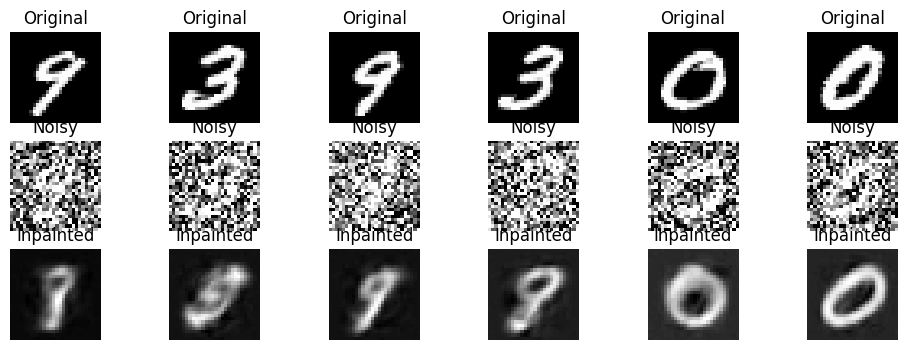

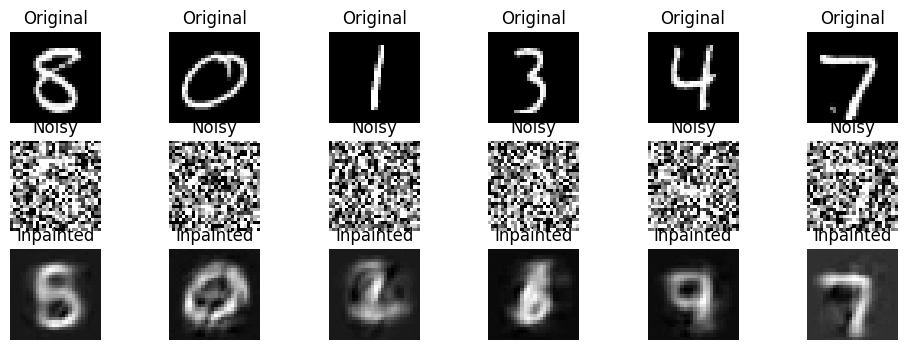

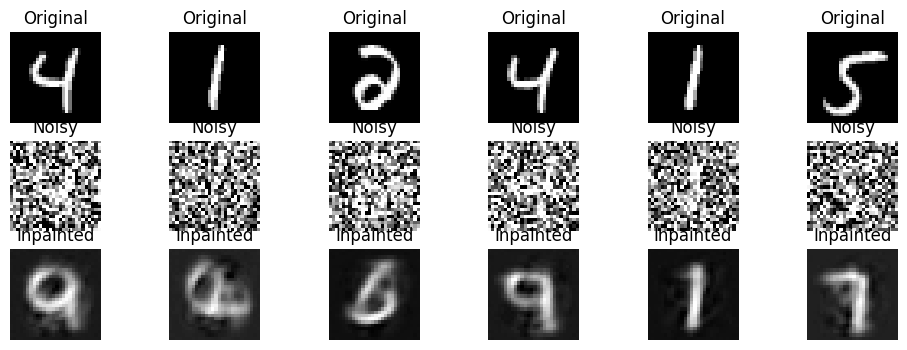

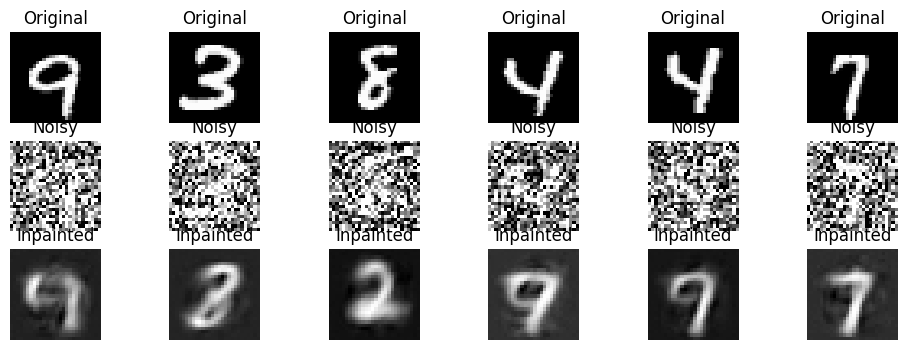

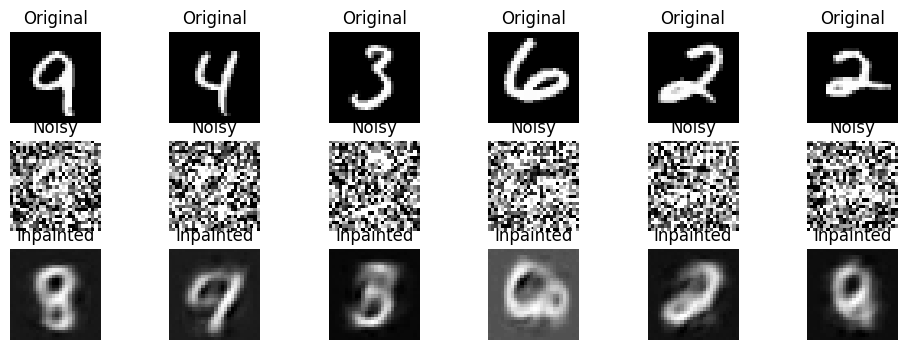

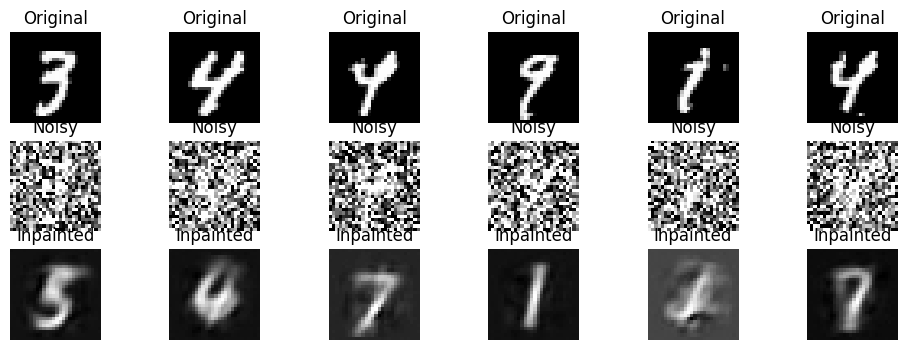

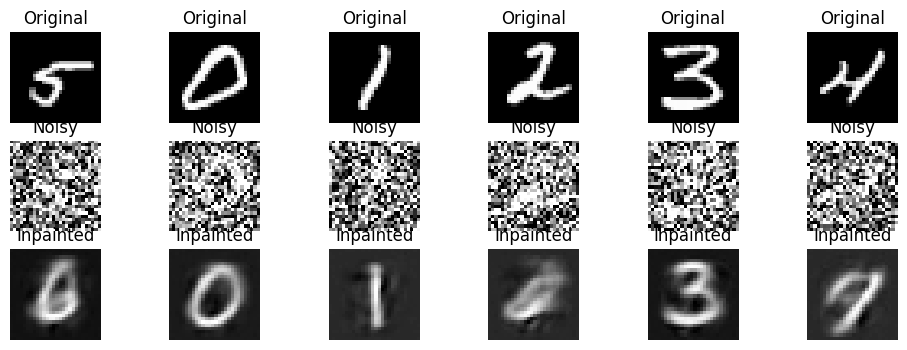

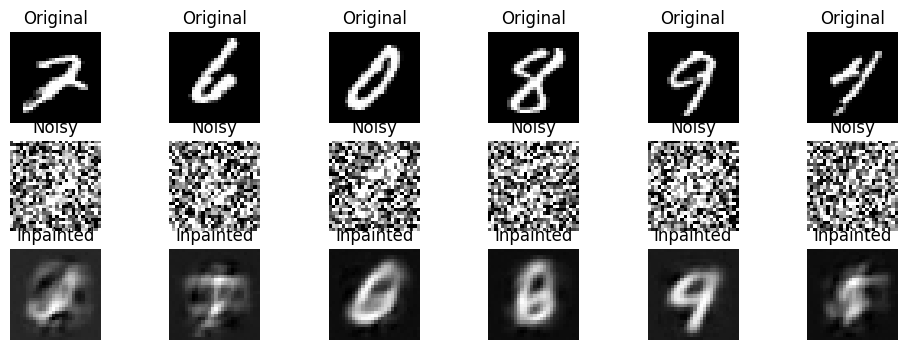

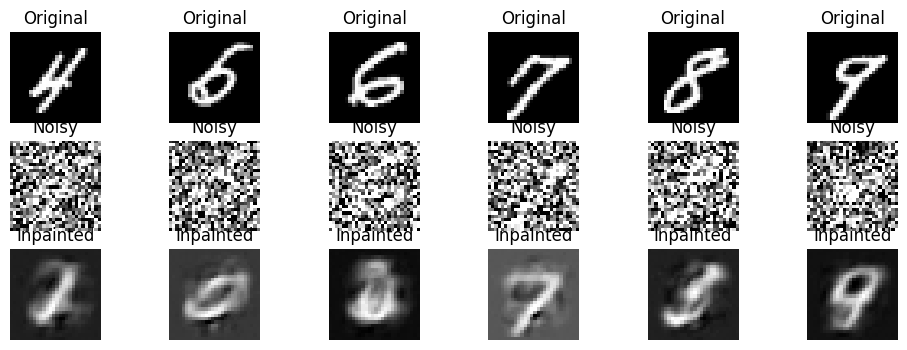

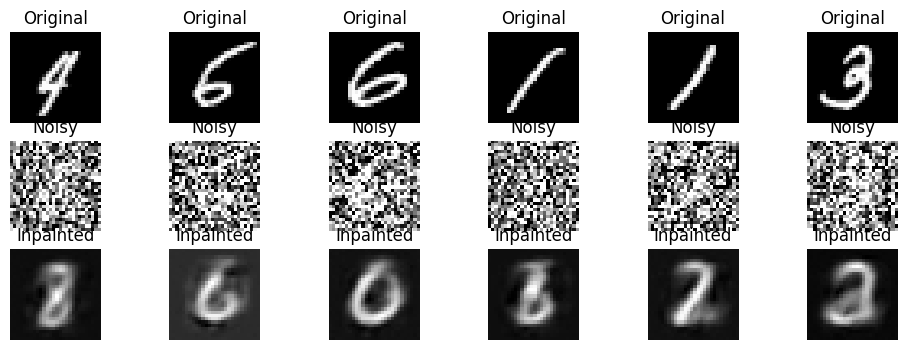

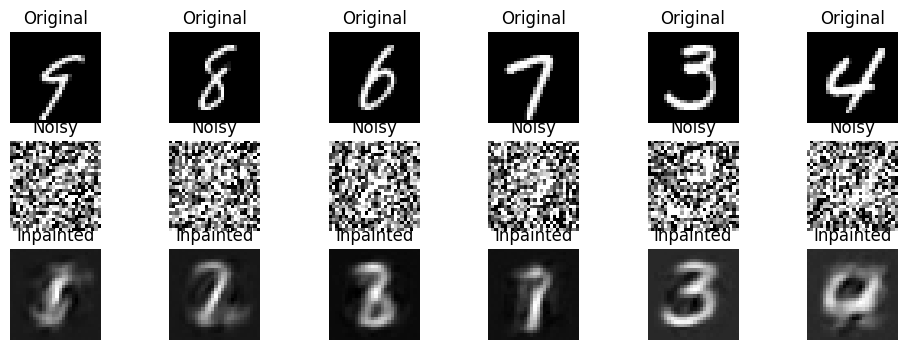

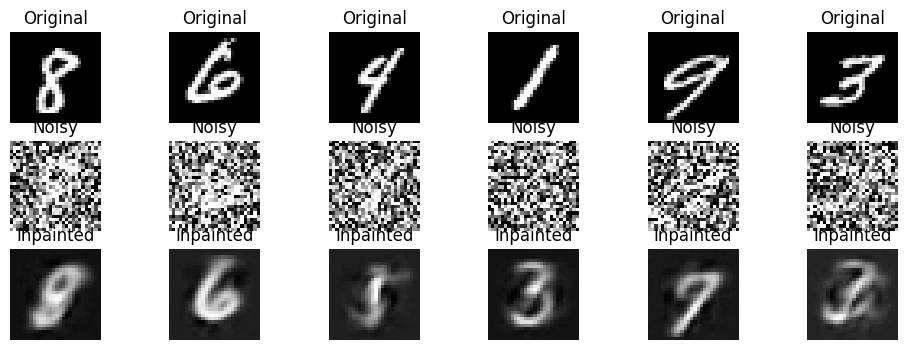

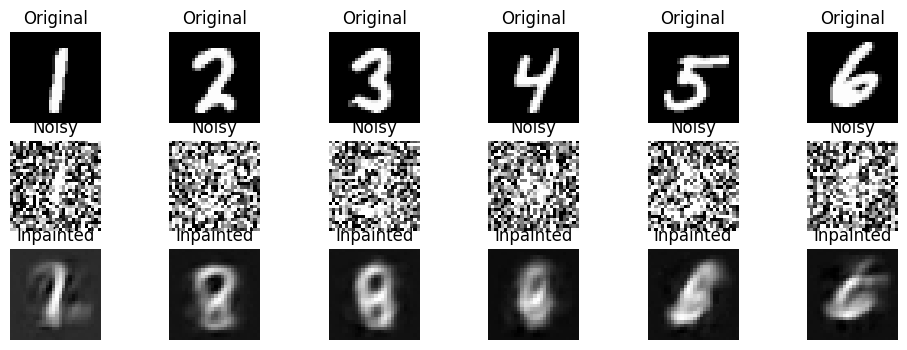

Test Loss: 525.3054118164063


In [3]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST Dataset
# We use transforms.ToTensor() to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Define VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for encoding
            nn.ReLU(),  # Activation function
            nn.Linear(hidden_dim, latent_dim * 2)  # Linear layer to output mean and log-variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),  # Linear layer for decoding
            nn.ReLU(),  # Activation function
            nn.Linear(hidden_dim, input_dim),  # Linear layer to reconstruct the input
            nn.Sigmoid()  # Activation function to ensure output is between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)  # Split the output into mean and log-variance
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Compute standard deviation from log-variance
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mu + eps * std  # Reparameterization trick to allow backpropagation

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)  # Encode the input to get mean and log-variance
        z = self.reparameterize(mu, log_var)  # Sample from the latent space
        return self.decode(z), mu, log_var  # Decode the latent representation

# Define Loss Function
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return BCE + KLD  # Total loss

# Training the VAE
input_dim = 28 * 28  # MNIST images are 28x28 pixels
hidden_dim = 400  # Size of the hidden layer
latent_dim = 20  # Size of the latent space
epochs = 10  # Number of training epochs

model = VAE(input_dim, hidden_dim, latent_dim).to(device)  # Initialize the VAE model
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Use Adam optimizer

# Train the VAE
model.train()
for epoch in range(epochs):
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, input_dim).to(device)  # Flatten the images and move to device
        data = (data + 1) / 2  # Scale the data to [0, 1]
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)  # Forward pass through the VAE
        loss = loss_function(recon_batch, data, mu, log_var)  # Compute the loss
        loss.backward()  # Backward pass
        train_loss += loss.item()  # Accumulate the loss
        optimizer.step()  # Update the model parameters

    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')

# Inpainting Function
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)  # Add Gaussian noise
    noisy_imgs = torch.clip(noisy_imgs, 0., 1.)  # Clip the values to [0, 1]
    return noisy_imgs

def inpaint(model, data):
    model.eval()
    with torch.no_grad():
        mu, log_var = model.encode(data)  # Encode the noisy images
        z = model.reparameterize(mu, log_var)  # Sample from the latent space
        recon_data = model.decode(z)  # Decode the latent representation
    return recon_data

# Testing the VAE and Inpainting
model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, input_dim).to(device)  # Flatten the images and move to device
        data = (data + 1) / 2  # Scale the data to [0, 1]
        noisy_data = add_noise(data)  # Add noise to the data
        recon_batch = inpaint(model, noisy_data)  # Inpaint the noisy data
        test_loss += loss_function(recon_batch, data, *model.encode(data)).item()

        # Visualize the original, noisy, and inpainted images
        plt.figure(figsize=(12, 4))
        for i in range(6):
            # Original images
            plt.subplot(3, 6, i+1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Noisy images
            plt.subplot(3, 6, i+7)
            plt.imshow(noisy_data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Noisy')
            plt.axis('off')

            # Inpainted images
            plt.subplot(3, 6, i+13)
            plt.imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Inpainted')
            plt.axis('off')
        plt.show()

    print(f'Test Loss: {test_loss / len(test_loader.dataset)}')
